In [112]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-



import argparse
import os
import sys
import math
import json
import random
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
from scipy import sparse

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier



In [113]:
# Optional libs
try:
    import shap
    HAS_SHAP = True
except Exception:
    HAS_SHAP = False

try:
    import matplotlib.pyplot as plt
    HAS_MPL = True
except Exception:
    HAS_MPL = False


In [114]:

# ---------------------------
# Utilities
# ---------------------------

def ensure_dir(path: str):
    os.makedirs(path, exist_ok=True)

def seed_everything(seed=42):
    random.seed(seed); np.random.seed(seed)

def read_csv_safe(path, **kwargs):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing required file: {path}")
    return pd.read_csv(path, **kwargs)

In [115]:
# ---------------------------
# Data Loading
# ---------------------------

def load_core(data_dir: str):
    aisles = read_csv_safe(os.path.join(data_dir, "aisles.csv"))
    depts  = read_csv_safe(os.path.join(data_dir, "departments.csv"))
    prods  = read_csv_safe(os.path.join(data_dir, "products.csv"))
    orders = read_csv_safe(os.path.join(data_dir, "orders.csv"))
    opt    = read_csv_safe(os.path.join(data_dir, "order_products__train.csv"))

    for df in (aisles, depts, prods, orders, opt):
        for c in df.columns:
            if df[c].dtype == object:
                df[c] = df[c].astype(str).str.strip()

    prods = prods.merge(aisles, on="aisle_id", how="left").merge(depts, on="department_id", how="left")
    return aisles, depts, prods, orders, opt

def prior_path(data_dir: str):
    path = os.path.join(data_dir, "order_products__prior.csv")
    return path if os.path.exists(path) else None

In [116]:
# ---------------------------
# Feature Engineering
# ---------------------------

def build_user_features_from_orders(op_like: pd.DataFrame, prods: pd.DataFrame) -> pd.DataFrame:
    # op_like columns expected: user_id, order_id, product_id, order_dow, order_hour_of_day, days_since_prior_order
    op = op_like.merge(prods[["product_id", "department", "aisle"]], on="product_id", how="left")
    basket_sizes = op.groupby(["user_id", "order_id"]).size().rename("basket_size")
    user_basket_stats = basket_sizes.groupby("user_id").agg(
        avg_basket_size="mean", std_basket_size="std", max_basket_size="max", min_basket_size="min"
    ).fillna(0.0)

    distinct_products   = op.groupby("user_id")["product_id"].nunique().rename("n_distinct_products")
    distinct_departments= op.groupby("user_id")["department"].nunique(dropna=True).rename("n_distinct_departments")
    distinct_aisles     = op.groupby("user_id")["aisle"].nunique(dropna=True).rename("n_distinct_aisles")

    order_stats = op_like.groupby("user_id").agg(
        n_orders=("order_id","nunique"),
        mean_order_hour=("order_hour_of_day","mean"),
        std_order_hour=("order_hour_of_day","std"),
        mean_order_dow=("order_dow","mean"),
        std_order_dow=("order_dow","std"),
        mean_days_since_prior=("days_since_prior_order","mean"),
        std_days_since_prior=("days_since_prior_order","std"),
    ).fillna(0.0)

    dept_distribution = (
        op.pivot_table(index="user_id", columns="department", values="product_id", aggfunc="count", fill_value=0)
          .pipe(lambda df: df.div(df.sum(axis=1).replace(0,1), axis=0))
    )

    aisle_counts = op.pivot_table(index="user_id", columns="aisle", values="product_id", aggfunc="count", fill_value=0)
    probs = aisle_counts.div(aisle_counts.sum(axis=1).replace(0,1), axis=0)
    aisle_entropy = - (probs.replace(0,np.nan) * np.log2(probs.replace(0,np.nan))).sum(axis=1).fillna(0.0)
    aisle_entropy.name = "aisle_entropy"

    feats = (pd.concat([user_basket_stats, distinct_products, distinct_departments, distinct_aisles,
                        order_stats, aisle_entropy], axis=1).fillna(0.0))
    feats = feats.join(dept_distribution, how="left").fillna(0.0)
    feats.reset_index(inplace=True)
    return feats

def scale_features(df: pd.DataFrame, exclude=("user_id",)):
    cols = [c for c in df.columns if c not in exclude]
    scaler = MinMaxScaler()
    Xs = pd.DataFrame(scaler.fit_transform(df[cols]), columns=cols, index=df.index)
    return pd.concat([df[list(exclude)], Xs], axis=1), scaler, cols


In [117]:
# ---------------------------
# Segmentation
# ---------------------------

def kmeans_select(X, k_grid, rs=42):
    elbow=[]; sils=[]; models={}
    for k in k_grid:
        km = KMeans(n_clusters=k, random_state=rs, n_init="auto")
        labels = km.fit_predict(X)
        elbow.append((k, km.inertia_))
        sil = silhouette_score(X, labels) if len(set(labels))>1 else -1
        sils.append((k, sil)); models[k]=(km, labels)
    best_k = sorted(sils, key=lambda t:(-t[1], t[0]))[0][0]
    return best_k, *models[best_k], elbow, sils

def dbscan_sweep(X, eps_grid=(0.2,0.3,0.4,0.5), min_samples=10):
    best=None; best_s=-1e9; results=[]
    for eps in eps_grid:
        db=DBSCAN(eps=eps, min_samples=min_samples)
        labels=db.fit_predict(X)
        uniq=set(labels)
        if len(uniq-{-1})<=1: s=-1
        else:
            m=labels!=-1; s=silhouette_score(X[m], labels[m]) if m.any() else -1
        results.append((eps,s,Counter(labels)))
        if s>best_s: best_s=s; best=(db,labels,eps)
    return best, results

def summarize_clusters(assign_df, feats_scaled, top_n=10):
    df = assign_df.merge(feats_scaled, on="user_id", how="left")
    num_cols=[c for c in df.columns if c not in ("user_id","cluster","algo") and np.issubdtype(df[c].dtype,np.number)]
    summary=df.groupby(["algo","cluster"])[num_cols].mean().reset_index()
    non_dept = {"avg_basket_size","std_basket_size","max_basket_size","min_basket_size",
                "n_distinct_products","n_distinct_departments","n_distinct_aisles",
                "n_orders","mean_order_hour","std_order_hour","mean_order_dow","std_order_dow",
                "mean_days_since_prior","std_days_since_prior","aisle_entropy"}
    dept_cols=[c for c in num_cols if c not in non_dept]
    rows=[]
    for _,r in summary.iterrows():
        depts=sorted([(c,r[c]) for c in dept_cols], key=lambda t:t[1], reverse=True)[:top_n]
        rows.append({"algo":r["algo"], "cluster":int(r["cluster"]),
                     "top_departments": json.dumps([d for d,_ in depts])})
    return summary.merge(pd.DataFrame(rows), on=["algo","cluster"], how="left")



In [118]:

# ---------------------------
# Recommenders (Hybrid)
# ---------------------------

def _cosine_rows(A: np.ndarray, B: np.ndarray):
    An=np.linalg.norm(A,axis=1,keepdims=True)+1e-9
    Bn=np.linalg.norm(B,axis=1,keepdims=True)+1e-9
    return (A @ B.T)/(An*Bn.T+1e-12)

def score_hybrid(user_seen_items: set,
                 II_sparse: sparse.csr_matrix,
                 content_matrix: sparse.csr_matrix,
                 popularity: np.ndarray,
                 Uemb: np.ndarray,
                 Vemb: np.ndarray,
                 uidx: int,
                 alpha=0.45, beta=0.25, gamma=0.20, delta=0.10,
                 max_neighbors=50):
    n_items = II_sparse.shape[0]
    seen_idx = np.array(sorted(list(user_seen_items)), dtype=int)
    s_cf = np.zeros(n_items); s_ct = np.zeros(n_items); s_em = np.zeros(n_items); s_po = popularity.copy()

    if seen_idx.size>0:
        # Item-CF via co-visitation top-N neighbors (already sparse & capped)
        sims = II_sparse[:, seen_idx].toarray()  # n_items x |seen|
        if max_neighbors and sims.size>0:
            # Keep top neighbors per seen column to denoise
            for j in range(sims.shape[1]):
                col=sims[:,j]
                if max_neighbors < len(col):
                    t=np.partition(col, -max_neighbors)[-max_neighbors]
                    col[col<t]=0.0; sims[:,j]=col
        s_cf = sims.sum(axis=1)

        # Content-based: centroid of seen items
        seen_content = content_matrix[seen_idx, :]
        centroid = seen_content.mean(axis=0)
        denom = np.sqrt(centroid.multiply(centroid).sum()) + 1e-9
        if denom>0:
            numer = content_matrix @ centroid.T
            norms = np.sqrt(content_matrix.multiply(content_matrix).sum(axis=1)) + 1e-9
            s_ct = (numer.A.ravel())/(np.array(norms).ravel()*denom)

    if Uemb is not None and Vemb is not None:
        u_vec = Uemb[uidx:uidx+1, :]
        s_em = _cosine_rows(u_vec, Vemb).ravel()

    def _mm(x):
        x=np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
        return (x-x.min())/(x.max()-x.min()+1e-9) if x.max()>x.min() else np.zeros_like(x)

    s = alpha*_mm(s_cf) + beta*_mm(s_ct) + gamma*_mm(s_em) + delta*_mm(s_po)
    return s, {"item_cf":_mm(s_cf),"content":_mm(s_ct),"embeddings":_mm(s_em),"popularity":_mm(s_po),
               "weights":dict(alpha=alpha,beta=beta,gamma=gamma,delta=delta)}


In [119]:

# ---------------------------
# PRIOR ingestion (chunked) -> UI, co-visitation II, popularity, user_seen
# ---------------------------

def build_prior_signals(data_dir: str,
                        orders: pd.DataFrame,
                        prods: pd.DataFrame,
                        chunksize: int = 5_000_000,
                        covisit_topn: int = 100,
                        max_basket_items: int = 50):
    prior_fp = prior_path(data_dir)
    if prior_fp is None:
        return None  # no prior

    # Map: order_id -> user_id for PRIOR orders
    prior_orders = orders.loc[orders["eval_set"]=="prior", ["order_id","user_id","order_dow","order_hour_of_day","days_since_prior_order"]]
    o2u = prior_orders.set_index("order_id")["user_id"]

    # Indexes for users and items (include PRIOR + TRAIN users so indices align later)
    all_users = pd.Index(sorted(orders["user_id"].unique()), name="user_id")
    all_items = pd.Index(sorted(prods["product_id"].unique()), name="product_id")
    u2i = {u:i for i,u in enumerate(all_users)}
    p2i = {p:i for i,p in enumerate(all_items)}

    # Popularity (counts), UI coords (rows, cols), user->set(items), and co-visitation (top-N per item)
    pop_counts = np.zeros(len(all_items), dtype=np.float32)
    rows=[]; cols=[]
    user_seen = defaultdict(set)
    covisit = defaultdict(Counter)

    # Stream prior in chunks
    usecols=["order_id","product_id","add_to_cart_order","reordered"]  # standard cols; robust to extras
    for chunk in pd.read_csv(prior_fp, usecols=usecols, chunksize=chunksize):
        # Attach user_id for this chunk
        chunk = chunk.merge(prior_orders[["order_id","user_id"]], on="order_id", how="left")
        chunk.dropna(subset=["user_id"], inplace=True)
        chunk["user_id"] = chunk["user_id"].astype(int)

        # Popularity + UI + user_seen
        chunk["ui_row"] = chunk["user_id"].map(u2i)
        chunk["ui_col"] = chunk["product_id"].map(p2i)
        c_valid = chunk.dropna(subset=["ui_row","ui_col"])
        r = c_valid["ui_row"].astype(int).to_numpy()
        c = c_valid["ui_col"].astype(int).to_numpy()
        rows.extend(r.tolist()); cols.extend(c.tolist())
        np.add.at(pop_counts, c, 1.0)
        for u, grp in c_valid.groupby("user_id"):
            user_idx = u2i[u]
            prods_idx = grp["ui_col"].astype(int).tolist()
            for it in prods_idx:
                user_seen[user_idx].add(it)

        # Co-visitation (cap basket size for speed/memory)
        for oid, grp in c_valid.groupby("order_id"):
            items = grp["ui_col"].astype(int).tolist()
            if len(items)>max_basket_items:
                # simple downsample to cap pair explosion
                items = items[:max_basket_items]
            uniq = list(dict.fromkeys(items))  # preserve order, dedupe
            for i in range(len(uniq)):
                a = uniq[i]
                for j in range(i+1, len(uniq)):
                    b = uniq[j]
                    covisit[a][b] += 1
                    covisit[b][a] += 1

            # prune to top-N per item
            for a in uniq:
                if len(covisit[a])>covisit_topn:
                    # keep N highest
                    covisit[a] = Counter(dict(covisit[a].most_common(covisit_topn)))

    # Build sparse UI (from prior)
    data = np.ones(len(rows), dtype=np.float32)
    UI = sparse.csr_matrix((data, (np.array(rows), np.array(cols))), shape=(len(all_users), len(all_items)))

    # Normalize popularity
    pop = pop_counts / (pop_counts.max() if pop_counts.max()>0 else 1.0)

    # Build sparse II (co-visitation) from capped counters, and convert to cosine-like
    indptr=[0]; indices=[]; vals=[]
    deg = np.zeros(len(all_items), dtype=np.float32)
    for a in range(len(all_items)):
        neigh = covisit.get(a)
        if not neigh:
            indptr.append(indptr[-1]); continue
        items_idx, counts = zip(*neigh.items())
        indices.extend(items_idx); vals.extend(counts)
        indptr.append(indptr[-1] + len(items_idx))
        deg[a] = sum(counts)

    II = sparse.csr_matrix((np.array(vals, dtype=np.float32),
                            np.array(indices, dtype=np.int32),
                            np.array(indptr, dtype=np.int32)),
                           shape=(len(all_items), len(all_items)))
    II.setdiag(0)

    # Cosine-like symmetrization: sim(a,b) = c(a,b)/sqrt(deg(a)*deg(b))
    deg = np.maximum(deg, 1e-9)
    d_inv_sqrt = 1.0/np.sqrt(deg)
    D = sparse.diags(d_inv_sqrt)
    II = D @ II @ D  # normalized

    # Content features
    meta = prods.set_index("product_id").reindex(all_items)
    cat = meta[["department","aisle"]].fillna("Unknown")
    ohe = OneHotEncoder(sparse=True, handle_unknown="ignore")
    X_content = ohe.fit_transform(cat)

    return {
        "UI": UI,
        "II": II.tocsr(),
        "users_index": all_users,
        "items_index": all_items,
        "u2i": u2i,
        "p2i": p2i,
        "popularity": pop,
        "content_ohe": ohe,
        "content_matrix": X_content,
        "user_seen": user_seen
    }


def train_embeddings(UI: sparse.csr_matrix, n_components=64, random_state=42):
    try:
        UI = UI.astype(float)
        # TF-like reweighting
        df_items = np.asarray((UI>0).sum(axis=0)).ravel()
        idf = np.log(1 + UI.shape[0]/(1+df_items))
        UIw = UI.multiply(idf)
        svd = TruncatedSVD(n_components=n_components, random_state=random_state)
        U = svd.fit_transform(UIw)
        V = svd.components_.T
        return U, V, svd.explained_variance_ratio_.sum()
    except MemoryError:
        # graceful fallback: skip embeddings
        return None, None, 0.0



In [120]:

# ---------------------------
# Evaluation
# ---------------------------

def eval_next_order(opt_train: pd.DataFrame,
                    mats: dict,
                    alpha: float, beta: float, gamma: float, delta: float,
                    max_neighbors: int,
                    topk: list):
    """
    Evaluate predictions for each user's next (train) order using PRIOR-trained signals.
    """
    users_index = mats["users_index"]; items_index = mats["items_index"]
    u2i, p2i = mats["u2i"], mats["p2i"]
    II = mats["II"]; pop = mats["popularity"]; Xc = mats["content_matrix"]
    Uemb = mats.get("Uemb"); Vemb = mats.get("Vemb")
    user_seen = mats["user_seen"]

    # Ground truth per user from train
    gt = (opt_train.groupby("user_id")["product_id"].apply(list))

    rows_eval=[]; rec_rows=[]
    for uid, truth_p in gt.items():
        if uid not in u2i:  # user with no prior history
            continue
        uidx = u2i[uid]
        truth_idx = { p2i[p] for p in truth_p if p in p2i }
        seen = user_seen.get(uidx, set())

        scores, breakdown = score_hybrid(
            user_seen_items=seen,
            II_sparse=II,
            content_matrix=Xc,
            popularity=pop,
            Uemb=Uemb, Vemb=Vemb, uidx=uidx,
            alpha=alpha, beta=beta, gamma=gamma, delta=delta,
            max_neighbors=max_neighbors
        )

        # (Option) emphasize reorders by lightly boosting seen items
        if len(seen)>0:
            boost = 0.05
            s_mod = scores.copy()
            s_mod[list(seen)] += boost
            scores = s_mod

        ranked = np.argsort(-scores)
        for K in topk:
            pick = set(ranked[:K].tolist())
            hits = len(pick & truth_idx)
            prec = hits / max(K,1)
            rec  = hits / max(len(truth_idx),1)
            f1   = (2*prec*rec/(prec+rec)) if (prec+rec)>0 else 0.0
            hr   = 1.0 if hits>0 else 0.0
            rows_eval.append({"user_id":uid,"K":K,"precision":prec,"recall":rec,"f1":f1,"hit_rate":hr})

        # Save top-20 per user with contributions
        Ksave = max(topk)
        top_idx = ranked[:Ksave]
        for rank, it_idx in enumerate(top_idx, start=1):
            rec_rows.append({
                "user_id": uid,
                "order_id": np.nan,  # next order; unknown id here
                "rank": rank,
                "product_id": int(items_index[it_idx]),
                "score_total": float(scores[it_idx]),
                "contrib_item_cf": float(breakdown["item_cf"][it_idx]),
                "contrib_content": float(breakdown["content"][it_idx]),
                "contrib_embeddings": float(breakdown["embeddings"][it_idx]) if Uemb is not None else 0.0,
                "contrib_popularity": float(breakdown["popularity"][it_idx]),
            })

    eval_df = pd.DataFrame(rows_eval)
    eval_agg = (eval_df.groupby("K").agg(precision=("precision","mean"),
                                         recall=("recall","mean"),
                                         f1=("f1","mean"),
                                         hit_rate=("hit_rate","mean")).reset_index()
                if not eval_df.empty else pd.DataFrame())
    recs_df = pd.DataFrame(rec_rows)
    return eval_agg, recs_df


In [122]:
# === Export artifacts for Streamlit app ===
from pathlib import Path
from scipy import sparse
import numpy as np, joblib

artifacts_dir = Path.cwd() / "artifacts"
model_dir = artifacts_dir / "model"
model_dir.mkdir(parents=True, exist_ok=True)

# core matrices
sparse.save_npz(model_dir / "II_covisit.npz", mats["II"].tocsr())
sparse.save_npz(model_dir / "X_content.npz", mats["content_matrix"].tocsr())
np.save(model_dir / "popularity.npy", mats["popularity"].astype(np.float32))

# indices & maps
idx_maps = {
    "users_index": mats["users_index"].tolist(),
    "items_index": mats["items_index"].tolist(),
    "u2i": mats["u2i"],
    "p2i": mats["p2i"],
}
joblib.dump(idx_maps, model_dir / "indices_maps.joblib")

# user histories
joblib.dump(mats["user_seen"], model_dir / "user_seen.joblib")

# optional interactions & embeddings (if you have them)
if "UI" in mats:
    sparse.save_npz(model_dir / "UI_interactions.npz", mats["UI"].tocsr())
if mats.get("Uemb") is not None and mats.get("Vemb") is not None:
    np.save(model_dir / "Uemb.npy", mats["Uemb"])
    np.save(model_dir / "Vemb.npy", mats["Vemb"])

print("✅ exported to:", model_dir)


✅ exported to: /Users/yashwinnair/Desktop/finalq/artifacts/model


In [123]:


# ---------------------------
# Evaluation
# ---------------------------

def eval_next_order(opt_train: pd.DataFrame,
                    mats: dict,
                    alpha: float, beta: float, gamma: float, delta: float,
                    max_neighbors: int,
                    topk: list):
    """
    Evaluate predictions for each user's next (train) order using PRIOR-trained signals.
    """
    users_index = mats["users_index"]; items_index = mats["items_index"]
    u2i, p2i = mats["u2i"], mats["p2i"]
    II = mats["II"]; pop = mats["popularity"]; Xc = mats["content_matrix"]
    Uemb = mats.get("Uemb"); Vemb = mats.get("Vemb")
    user_seen = mats["user_seen"]

    # Ground truth per user from train
    gt = (opt_train.groupby("user_id")["product_id"].apply(list))

    rows_eval=[]; rec_rows=[]
    for uid, truth_p in gt.items():
        if uid not in u2i:  # user with no prior history
            continue
        uidx = u2i[uid]
        truth_idx = { p2i[p] for p in truth_p if p in p2i }
        seen = user_seen.get(uidx, set())

        scores, breakdown = score_hybrid(
            user_seen_items=seen,
            II_sparse=II,
            content_matrix=Xc,
            popularity=pop,
            Uemb=Uemb, Vemb=Vemb, uidx=uidx,
            alpha=alpha, beta=beta, gamma=gamma, delta=delta,
            max_neighbors=max_neighbors
        )

        # (Option) emphasize reorders by lightly boosting seen items
        if len(seen)>0:
            boost = 0.05
            s_mod = scores.copy()
            s_mod[list(seen)] += boost
            scores = s_mod

        ranked = np.argsort(-scores)
        for K in topk:
            pick = set(ranked[:K].tolist())
            hits = len(pick & truth_idx)
            prec = hits / max(K,1)
            rec  = hits / max(len(truth_idx),1)
            f1   = (2*prec*rec/(prec+rec)) if (prec+rec)>0 else 0.0
            hr   = 1.0 if hits>0 else 0.0
            rows_eval.append({"user_id":uid,"K":K,"precision":prec,"recall":rec,"f1":f1,"hit_rate":hr})

        # Save top-20 per user with contributions
        Ksave = max(topk)
        top_idx = ranked[:Ksave]
        for rank, it_idx in enumerate(top_idx, start=1):
            rec_rows.append({
                "user_id": uid,
                "order_id": np.nan,  # next order; unknown id here
                "rank": rank,
                "product_id": int(items_index[it_idx]),
                "score_total": float(scores[it_idx]),
                "contrib_item_cf": float(breakdown["item_cf"][it_idx]),
                "contrib_content": float(breakdown["content"][it_idx]),
                "contrib_embeddings": float(breakdown["embeddings"][it_idx]) if Uemb is not None else 0.0,
                "contrib_popularity": float(breakdown["popularity"][it_idx]),
            })

    eval_df = pd.DataFrame(rows_eval)
    eval_agg = (eval_df.groupby("K").agg(precision=("precision","mean"),
                                         recall=("recall","mean"),
                                         f1=("f1","mean"),
                                         hit_rate=("hit_rate","mean")).reset_index()
                if not eval_df.empty else pd.DataFrame())
    recs_df = pd.DataFrame(rec_rows)
    return eval_agg, recs_df



In [124]:

# ---------------------------
# Explainability (Segments)
# ---------------------------

def explain_segments_with_surrogate(feats_scaled, assignments, feature_cols, artifacts_dir):
    df = assignments.merge(feats_scaled[["user_id"]+feature_cols], on="user_id", how="left")
    X = df[feature_cols].values; y = df["cluster"].astype(int).values
    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
    clf.fit(X,y)
    importances = pd.Series(clf.feature_importances_, index=feature_cols).sort_values(ascending=False)
    out = importances.rename_axis("feature").reset_index(name="importance")
    out.to_csv(os.path.join(artifacts_dir, "segments", "surrogate_feature_importances.csv"), index=False)

    if HAS_SHAP:
        expl = shap.TreeExplainer(clf); sv = expl.shap_values(X)
        clusters = sorted(np.unique(y)); rows=[]
        for c_idx,c in enumerate(clusters):
            mean_abs = np.abs(sv[c_idx]).mean(axis=0)
            rows.append(pd.DataFrame({"cluster":c,"feature":feature_cols,"mean_abs_shap":mean_abs}))
        shap_df = pd.concat(rows, axis=0)
        shap_df.to_csv(os.path.join(artifacts_dir, "segments", "shap_mean_abs_by_cluster.csv"), index=False)
    return out


In [125]:


# ---------------------------
# Orchestration
# ---------------------------

def main(args):
    seed_everything(42)

    # Dirs
    feats_dir = os.path.join(args.artifacts_dir, "features"); ensure_dir(feats_dir)
    seg_dir   = os.path.join(args.artifacts_dir, "segments"); ensure_dir(seg_dir)
    rec_dir   = os.path.join(args.artifacts_dir, "recs"); ensure_dir(rec_dir)
    met_dir   = os.path.join(args.artifacts_dir, "metrics"); ensure_dir(met_dir)
    figs_dir  = os.path.join(args.artifacts_dir, "figs"); ensure_dir(figs_dir)

    # Load core
    aisles, depts, prods, orders, opt_train = load_core(args.data_dir)

    # === PRIOR-aware signals (if available)
    mats = build_prior_signals(
        data_dir=args.data_dir,
        orders=orders,
        prods=prods,
        chunksize=args.prior_chunksize,
        covisit_topn=args.covisit_topn,
        max_basket_items=args.max_basket_items
    )

    # === Features for segmentation
    if mats is not None:
        # Build features from PRIOR (join order-level time cols)
        prior_orders = orders.loc[orders["eval_set"]=="prior", ["order_id","user_id","order_dow","order_hour_of_day","days_since_prior_order"]]
        prior_fp = prior_path(args.data_dir)
        # Consume prior in chunks to assemble a slim op-like table for features
        parts=[]
        usecols=["order_id","product_id"]
        for chunk in pd.read_csv(prior_fp, usecols=usecols, chunksize=args.prior_chunksize):
            chunk = chunk.merge(prior_orders, on="order_id", how="left").dropna(subset=["user_id"])
            parts.append(chunk[["user_id","order_id","product_id","order_dow","order_hour_of_day","days_since_prior_order"]])
            if len(parts)>=3:  # keep memory in check by flushing periodically
                tmp = pd.concat(parts, axis=0)
                if 'op_prior_tmp.parquet' not in os.listdir(args.artifacts_dir):
                    tmp.to_parquet(os.path.join(args.artifacts_dir,"op_prior_tmp.parquet"))
                else:
                    tmp.to_parquet(os.path.join(args.artifacts_dir,"op_prior_tmp.parquet"), append=True)
                parts=[]

        if parts:
            tmp = pd.concat(parts, axis=0)
            if 'op_prior_tmp.parquet' not in os.listdir(args.artifacts_dir):
                tmp.to_parquet(os.path.join(args.artifacts_dir,"op_prior_tmp.parquet"))
            else:
                tmp.to_parquet(os.path.join(args.artifacts_dir,"op_prior_tmp.parquet"), append=True)

        # Read back the temp parquet(s)
        op_prior = pd.read_parquet(os.path.join(args.artifacts_dir,"op_prior_tmp.parquet"))
        feats = build_user_features_from_orders(op_prior, prods)
    else:
        # Fall back to TRAIN-only features
        train_orders = orders.loc[orders["eval_set"]=="train", ["order_id","user_id","order_dow","order_hour_of_day","days_since_prior_order"]]
        optu = opt_train.merge(train_orders, on="order_id", how="left").dropna(subset=["user_id"])
        feats = build_user_features_from_orders(optu, prods)

    feats.to_csv(os.path.join(feats_dir, "user_features_raw.csv"), index=False)
    feats_scaled, scaler, feature_cols = scale_features(feats, exclude=("user_id",))
    feats_scaled.to_csv(os.path.join(feats_dir, "user_features_scaled.csv"), index=False)

    # === Segmentation
    X = feats_scaled[feature_cols].values
    best_k, km_model, km_labels, elbow, sils = kmeans_select(X, args.k_grid, rs=42)
    kmeans_assign = pd.DataFrame({"user_id":feats_scaled["user_id"], "cluster":km_labels})
    kmeans_assign["algo"]=f"kmeans_k={best_k}"
    kmeans_assign.to_csv(os.path.join(seg_dir,"kmeans_assignments.csv"), index=False)

    elbow_df = pd.DataFrame(elbow, columns=["k","inertia"])
    sil_df   = pd.DataFrame(sils, columns=["k","silhouette"])
    elbow_df.to_csv(os.path.join(seg_dir,"kmeans_elbow.csv"), index=False)
    sil_df.to_csv(os.path.join(seg_dir,"kmeans_silhouette.csv"), index=False)
    if HAS_MPL:
        plt.figure(); plt.plot(elbow_df.k, elbow_df.inertia, marker="o"); plt.title("K-Means Elbow"); plt.savefig(os.path.join(figs_dir,"kmeans_elbow.png"), bbox_inches="tight"); plt.close()
        plt.figure(); plt.plot(sil_df.k, sil_df.silhouette, marker="o"); plt.title("K-Means Silhouette"); plt.savefig(os.path.join(figs_dir,"kmeans_silhouette.png"), bbox_inches="tight"); plt.close()

    (db_model, db_labels, db_eps), _ = dbscan_sweep(X, eps_grid=args.dbscan_eps_grid, min_samples=args.dbscan_min_samples)
    db_assign = pd.DataFrame({"user_id":feats_scaled["user_id"], "cluster":db_labels})
    db_assign["algo"]=f"dbscan_eps={db_eps}_min={args.dbscan_min_samples}"
    db_assign.to_csv(os.path.join(seg_dir,"dbscan_assignments.csv"), index=False)

    assign_all = pd.concat([kmeans_assign, db_assign], axis=0, ignore_index=True)
    profiles = summarize_clusters(assign_all, feats_scaled, top_n=10)
    profiles.to_csv(os.path.join(seg_dir,"cluster_profiles.csv"), index=False)

    _ = explain_segments_with_surrogate(feats_scaled, kmeans_assign, feature_cols, args.artifacts_dir)

In [126]:
# --- Notebook bootstrap so the evaluation cell can run standalone ---

import os, pandas as pd, numpy as np
from scipy import sparse
from collections import defaultdict, Counter
from sklearn.preprocessing import OneHotEncoder

# Paths (adjust if needed)
data_dir = "/Users/yashwinnair/Desktop/finalq"   # <-- change if needed

# A writable folder for outputs, under your current notebook directory:
artifacts_dir = Path.cwd() / "artifacts"         
artifacts_dir.mkdir(parents=True, exist_ok=True)

# Minimal args shim for the evaluation code
class Args:
    covisit_topn = 100       # neighbors to keep per item in co-visitation
    max_neighbors = 50       # neighbors consulted per seen item at scoring
    alpha = 0.45             # item-CF weight
    beta  = 0.25             # content weight
    gamma = 0.20             # embeddings weight
    delta = 0.10             # popularity weight
    topk  = [5, 10, 20]      # metrics @K
args = Args()

# Load core data if missing
try:
    orders
except NameError:
    try:
        # If you have load_core(...) from the script, use it
        aisles, depts, prods, orders, opt_train = load_core(data_dir)
    except NameError:
        # Fallback: raw reads
        aisles = pd.read_csv(os.path.join(data_dir, "aisles.csv"))
        depts  = pd.read_csv(os.path.join(data_dir, "departments.csv"))
        prods  = (pd.read_csv(os.path.join(data_dir, "products.csv"))
                  .merge(aisles, on="aisle_id", how="left")
                  .merge(depts,  on="department_id", how="left"))
        orders = pd.read_csv(os.path.join(data_dir, "orders.csv"))
        opt_train = pd.read_csv(os.path.join(data_dir, "order_products__train.csv"))

# Ensure `mats` exists (PRIOR signals). If you didn’t run the PRIOR build, this keeps it None.
try:
    mats
except NameError:
    mats = None



In [127]:
# === Recommenders + Evaluation (full, notebook-safe) ===
from pathlib import Path
import os, numpy as np, pandas as pd
from collections import defaultdict, Counter
from scipy import sparse

# ---------------------------
# Paths & artifacts setup
# ---------------------------
try:
    artifacts_dir  # your chosen output folder (Path or str)
except NameError:
    artifacts_dir = Path.cwd() / "artifacts"

artifacts_dir = Path(artifacts_dir)
for sub in ["features", "segments", "recs", "metrics", "figs"]:
    (artifacts_dir / sub).mkdir(parents=True, exist_ok=True)
met_dir = artifacts_dir / "metrics"
rec_dir = artifacts_dir / "recs"

# ---------------------------
# sklearn OneHotEncoder compat
# ---------------------------
from sklearn.preprocessing import OneHotEncoder
def make_ohe():
    try:
        return OneHotEncoder(sparse_output=True, handle_unknown="ignore")  # sklearn >= 1.4
    except TypeError:
        return OneHotEncoder(sparse=True, handle_unknown="ignore")         # sklearn < 1.4

# ---------------------------
# Helper functions
# ---------------------------
def _minmax(x: np.ndarray) -> np.ndarray:
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
    mx, mn = x.max(), x.min()
    return (x - mn) / (mx - mn + 1e-9) if mx > mn else np.zeros_like(x)

def _row_norms_sparse(X: sparse.csr_matrix) -> np.ndarray:
    # Efficient L2 norm per row of a sparse matrix
    return np.sqrt(X.multiply(X).sum(axis=1)).A1  # -> 1D ndarray

def _score_hybrid_inline(user_seen_items: set,
                         II_sparse: sparse.csr_matrix,
                         content_matrix: sparse.csr_matrix,
                         popularity: np.ndarray,
                         Uemb: np.ndarray,
                         Vemb: np.ndarray,
                         uidx: int,
                         alpha=0.45, beta=0.25, gamma=0.20, delta=0.10,
                         max_neighbors=50):
    """Hybrid scorer with sparse-safe content centroid."""
    n_items = II_sparse.shape[0]
    seen_idx = np.array(sorted(list(user_seen_items)), dtype=int)
    s_cf = np.zeros(n_items); s_ct = np.zeros(n_items); s_em = np.zeros(n_items); s_po = popularity.copy()

    # ---- item-based CF (co-visitation) ----
    if seen_idx.size > 0:
        sims = II_sparse[:, seen_idx].toarray()  # (n_items x |seen|)
        if max_neighbors and sims.size > 0:
            for j in range(sims.shape[1]):
                col = sims[:, j]
                if max_neighbors < len(col):
                    t = np.partition(col, -max_neighbors)[-max_neighbors]
                    col[col < t] = 0.0
                    sims[:, j] = col
        s_cf = sims.sum(axis=1)

        # ---- content similarity: centroid over seen items (sparse-safe) ----
        seen_content = content_matrix[seen_idx, :]                # sparse
        centroid = np.asarray(seen_content.mean(axis=0)).ravel()  # dense 1D
        norm_centroid = np.linalg.norm(centroid)
        if norm_centroid > 0:
            numer = content_matrix @ centroid                     # (n_items,)
            norms = _row_norms_sparse(content_matrix) + 1e-9
            s_ct = numer / (norms * (norm_centroid + 1e-9))

    # ---- embeddings (optional) ----
    if Uemb is not None and Vemb is not None:
        u_vec = Uemb[uidx:uidx+1, :]                                # (1, d)
        An = np.linalg.norm(u_vec, axis=1, keepdims=True) + 1e-9    # (1,1)
        Bn = (np.linalg.norm(Vemb, axis=1, keepdims=True) + 1e-9).T # (1, n_items)
        s_em = (u_vec @ Vemb.T).ravel() / (An * Bn).ravel()

    # ---- fuse channels ----
    total = alpha*_minmax(s_cf) + beta*_minmax(s_ct) + gamma*_minmax(s_em) + delta*_minmax(s_po)
    return total, {
        "item_cf": _minmax(s_cf),
        "content": _minmax(s_ct),
        "embeddings": _minmax(s_em),
        "popularity": _minmax(s_po),
    }

def eval_next_order_inline(opt_train_with_uid: pd.DataFrame,
                           mats: dict,
                           alpha: float, beta: float, gamma: float, delta: float,
                           max_neighbors: int,
                           topk: list[int]) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Evaluate top-K quality for predicting each user's next (train) order."""
    users_index = mats["users_index"]; items_index = mats["items_index"]
    u2i, p2i = mats["u2i"], mats["p2i"]
    II = mats["II"]; pop = mats["popularity"]; Xc = mats["content_matrix"]
    Uemb = mats.get("Uemb"); Vemb = mats.get("Vemb")
    user_seen = mats["user_seen"]

    # Ground truth per user from TRAIN (next order)
    gt = opt_train_with_uid.groupby("user_id")["product_id"].apply(list)

    rows_eval=[]; rec_rows=[]
    for uid, truth_p in gt.items():
        if uid not in u2i:
            continue
        uidx = u2i[uid]
        truth_idx = {p2i[p] for p in truth_p if p in p2i}
        seen = user_seen.get(uidx, set())

        scores, breakdown = _score_hybrid_inline(
            user_seen_items=seen,
            II_sparse=II, content_matrix=Xc, popularity=pop,
            Uemb=Uemb, Vemb=Vemb, uidx=uidx,
            alpha=alpha, beta=beta, gamma=gamma, delta=delta,
            max_neighbors=max_neighbors
        )

        # optional small reorder boost to seen items
        if len(seen) > 0:
            scores = scores.copy()
            scores[list(seen)] += 0.05

        ranked = np.argsort(-scores)
        for K in topk:
            pick = set(ranked[:K].tolist())
            hits = len(pick & truth_idx)
            prec = hits / max(K, 1)
            rec  = hits / max(len(truth_idx), 1)
            f1   = (2*prec*rec/(prec+rec)) if (prec+rec) > 0 else 0.0
            hr   = 1.0 if hits > 0 else 0.0
            rows_eval.append({"user_id": uid, "K": K, "precision": prec, "recall": rec, "f1": f1, "hit_rate": hr})

        # save top-N with contributions
        Ksave = max(topk)
        top_idx = ranked[:Ksave]
        for rank, it_idx in enumerate(top_idx, start=1):
            rec_rows.append({
                "user_id": uid,
                "rank": rank,
                "product_id": int(items_index[it_idx]),
                "score_total": float(scores[it_idx]),
                "contrib_item_cf": float(breakdown["item_cf"][it_idx]),
                "contrib_content": float(breakdown["content"][it_idx]),
                "contrib_embeddings": float(breakdown["embeddings"][it_idx]) if Uemb is not None else 0.0,
                "contrib_popularity": float(breakdown["popularity"][it_idx]),
            })

    eval_df = pd.DataFrame(rows_eval)
    eval_agg = (eval_df.groupby("K").agg(precision=("precision","mean"),
                                         recall=("recall","mean"),
                                         f1=("f1","mean"),
                                         hit_rate=("hit_rate","mean")).reset_index()
                if not eval_df.empty else pd.DataFrame())
    recs_df = pd.DataFrame(rec_rows)
    return eval_agg, recs_df


In [128]:


# ---------------------------
# Load data (orders/prods/opt_train)
# ---------------------------
try:
    orders, prods, opt_train
except NameError:
    try:
        aisles, depts, prods, orders, opt_train = load_core(str(data_dir))  # if you defined load_core earlier
    except NameError:
        # raw load (requires data_dir)
        if 'data_dir' not in globals():
            raise RuntimeError("data_dir is not defined. Set it to your Instacart folder.")
        data_dir = Path(data_dir)
        required = ["aisles.csv","departments.csv","products.csv","orders.csv","order_products__train.csv"]
        missing = [f for f in required if not (data_dir / f).exists()]
        if missing:
            raise FileNotFoundError(f"Missing {missing} in {data_dir}")
        aisles = pd.read_csv(data_dir / "aisles.csv")
        depts  = pd.read_csv(data_dir / "departments.csv")
        prods  = (pd.read_csv(data_dir / "products.csv")
                  .merge(aisles, on="aisle_id", how="left")
                  .merge(depts,  on="department_id", how="left"))
        orders = pd.read_csv(data_dir / "orders.csv")
        opt_train = pd.read_csv(data_dir / "order_products__train.csv")

# -------- attach user_id to order_products__train (critical!) --------
train_orders_map = orders.loc[orders["eval_set"]=="train", ["order_id","user_id"]]
opt_train_u = (opt_train
               .merge(train_orders_map, on="order_id", how="left")
               .dropna(subset=["user_id"])
               .assign(user_id=lambda d: d["user_id"].astype(int)))


In [129]:
# ============================================================
# Build signals (PRIOR if present else TRAIN), train embeddings,
# tune weights, evaluate @K, and save CSVs
# ============================================================
from pathlib import Path
import os, numpy as np, pandas as pd
from collections import defaultdict, Counter
from scipy import sparse
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

# --------- folders ---------
artifacts_dir = Path.cwd() / "artifacts"
met_dir = artifacts_dir / "metrics"
rec_dir = artifacts_dir / "recs"
met_dir.mkdir(parents=True, exist_ok=True)
rec_dir.mkdir(parents=True, exist_ok=True)

# --------- helpers ---------
def make_ohe():
    from sklearn.preprocessing import OneHotEncoder
    try:    return OneHotEncoder(sparse_output=True, handle_unknown="ignore")  # sklearn >=1.4
    except TypeError: return OneHotEncoder(sparse=True, handle_unknown="ignore")  # older sklearn

def _minmax(x: np.ndarray) -> np.ndarray:
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
    mx, mn = x.max(), x.min()
    return (x - mn) / (mx - mn + 1e-9) if mx > mn else np.zeros_like(x)

def _row_norms_sparse(X: sparse.csr_matrix) -> np.ndarray:
    return np.sqrt(X.multiply(X).sum(axis=1)).A1

# --------- configs (fast & accurate) ---------
LAST_N_ORDERS_PER_USER = 5       # for PRIOR speed
COVISIT_TOPN            = 150
MAX_BASKET_ITEMS        = 30
LAMBDA_DECAY            = 0.02   # time-decay per day
EMBED_DIM               = 96     # SVD dimension
TOPK_LIST               = [5,10,20]

# --------- detect PRIOR ---------
prior_fp = Path(data_dir) / "order_products__prior.csv"
use_prior = prior_fp.exists()


In [131]:

# ============================================================
# 1) Build mats_fast (PRIOR preferred; TRAIN fallback)
# ============================================================
if use_prior:
    print("[FAST] PRIOR found — building fast PRIOR signals.")
    po = orders.loc[orders.eval_set.eq("prior"),
                    ["order_id","user_id","order_number","days_since_prior_order"]].copy()
    po["days_since_prior_order"] = po["days_since_prior_order"].fillna(0)
    po.sort_values(["user_id","order_number"], inplace=True)
    max_ord = po.groupby("user_id")["order_number"].transform("max")
    po = po[po["order_number"] >= (max_ord - (LAST_N_ORDERS_PER_USER - 1))].copy()

    # time-decay
    po["cum_days"] = po.groupby("user_id")["days_since_prior_order"].cumsum()
    max_days = po.groupby("user_id")["cum_days"].transform("max")
    po["age_days"] = (max_days - po["cum_days"]).astype(float)
    po["w_time"]   = np.exp(-LAMBDA_DECAY * po["age_days"])

    keep_order_ids = set(po["order_id"].tolist())

    # dynamic indexing
    u2i, p2i = {}, {}
    users_by_idx, items_by_idx = [], []
    def iu(u):
        if u not in u2i: u2i[u]=len(u2i); users_by_idx.append(u)
        return u2i[u]
    def ip(p):
        if p not in p2i: p2i[p]=len(p2i); items_by_idx.append(p)
        return p2i[p]

    UI_r, UI_c, UI_v = [], [], []
    covisit = defaultdict(Counter)
    pop_counts = Counter(); reorder_w = Counter(); total_w = Counter()
    user_seen = defaultdict(set)

    seen_orders = 0
    for chunk in pd.read_csv(prior_fp, usecols=["order_id","product_id","reordered"], chunksize=1_000_000):
        c = chunk[chunk["order_id"].isin(keep_order_ids)]
        if c.empty: continue
        c = c.merge(po[["order_id","user_id","w_time"]], on="order_id", how="left").dropna(subset=["user_id"])
        c["user_id"] = c["user_id"].astype(int)
        c["product_id"] = c["product_id"].astype(int)
        c["reordered"]  = c["reordered"].fillna(0).astype(int)
        seen_orders += c["order_id"].nunique()

        r   = c["user_id"].map(iu).to_numpy()
        col = c["product_id"].map(ip).to_numpy()
        wt  = c["w_time"].astype(float).to_numpy()

        UI_r.extend(r.tolist()); UI_c.extend(col.tolist()); UI_v.extend(wt.tolist())

        for p, w, ro in zip(c["product_id"].to_numpy(), wt, c["reordered"].to_numpy()):
            pop_counts[p] += w; reorder_w[p] += (w*ro); total_w[p] += w

        for uid_idx, grp in c.groupby(r):
            for it in grp["product_id"].map(ip).astype(int).tolist():
                user_seen[int(uid_idx)].add(int(it))

        for oid, grp in c.groupby("order_id"):
            items = grp["product_id"].map(ip).astype(int).tolist()
            w     = float(grp["w_time"].iloc[0])
            if len(items) > MAX_BASKET_ITEMS: items = items[:MAX_BASKET_ITEMS]
            uniq = list(dict.fromkeys(items))
            L = len(uniq)
            for i in range(L):
                a = uniq[i]
                for j in range(i+1, L):
                    b = uniq[j]
                    covisit[a][b] += w; covisit[b][a] += w
            for a in uniq:
                if len(covisit[a]) > COVISIT_TOPN:
                    covisit[a] = Counter(dict(covisit[a].most_common(COVISIT_TOPN)))

        if seen_orders % 50000 == 0:
            print(f"[FAST] Processed ~{seen_orders:,} PRIOR orders...")

    users_index = pd.Index(users_by_idx, name="user_id")
    items_index = pd.Index(items_by_idx, name="product_id")

    UI = sparse.csr_matrix((np.array(UI_v, dtype=np.float32),
                            (np.array(UI_r, dtype=np.int32), np.array(UI_c, dtype=np.int32))),
                           shape=(len(users_index), len(items_index)))
    UI.sum_duplicates()

    freq = np.array([pop_counts.get(int(pid), 0.0) for pid in items_index], dtype=np.float64)
    rr   = np.array([reorder_w.get(int(pid), 0.0)/max(total_w.get(int(pid), 1e-9), 1e-9) for pid in items_index],
                    dtype=np.float64)
    pop = (0.5*_minmax(freq) + 0.5*_minmax(rr)).astype(np.float32)

    indptr=[0]; indices=[]; vals=[]; deg=np.zeros(len(items_index), dtype=np.float64)
    for a in range(len(items_index)):
        neigh = covisit.get(a)
        if not neigh: indptr.append(indptr[-1]); continue
        js, vs = zip(*neigh.items())
        indices.extend(js); vals.extend(vs); indptr.append(indptr[-1]+len(js)); deg[a]=sum(vs)
    II = sparse.csr_matrix((np.array(vals,dtype=np.float32),
                            np.array(indices,dtype=np.int32),
                            np.array(indptr,dtype=np.int32)),
                           shape=(len(items_index), len(items_index)))
    deg = np.maximum(deg, 1e-9); D = sparse.diags(1.0/np.sqrt(deg)); II = (D @ II @ D).tocsr(); II.setdiag(0)

    # content features aligned
    prods_ix = prods.set_index("product_id").reindex(items_index)
    cat   = prods_ix[["department","aisle"]].fillna("unknown")
    ohe   = make_ohe(); X_cat = ohe.fit_transform(cat)
    names = prods_ix["product_name"].fillna("").str.lower()
    tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=5, max_features=4000)
    X_name = tfidf.fit_transform(names)
    Xc    = sparse.hstack([X_cat, X_name]).tocsr()

    mats_fast = {
        "UI": UI, "II": II,
        "users_index": users_index, "items_index": items_index,
        "u2i": {u:i for i,u in enumerate(users_index)},
        "p2i": {p:i for i,p in enumerate(items_index)},
        "popularity": pop,
        "content_matrix": Xc,
        "user_seen": user_seen,
        "Uemb": None, "Vemb": None
    }
else:
    print("[INFO] PRIOR not found — building TRAIN-only signals (baseline).")
    items = sorted(prods["product_id"].unique()); items_index = pd.Index(items, name="product_id")
    p2i = {p:i for i,p in enumerate(items_index)}
    covisit = defaultdict(Counter); pop = np.zeros(len(items_index), dtype=np.float32); user_seen = defaultdict(set)
    for oid, grp in opt_train_u.groupby("order_id"):
        idxs=[p2i[p] for p in grp["product_id"].tolist() if p in p2i]
        for it in idxs: pop[it]+=1
        uniq=list(dict.fromkeys(idxs))
        for i in range(len(uniq)):
            a=uniq[i]
            for j in range(i+1,len(uniq)):
                b=uniq[j]; covisit[a][b]+=1; covisit[b][a]+=1
        uid=int(grp["user_id"].iloc[0])
        for it in uniq: user_seen[uid].add(it)
    indptr=[0]; indices=[]; vals=[]; deg=np.zeros(len(items_index), dtype=np.float32)
    for a in range(len(items_index)):
        neigh=covisit.get(a)
        if not neigh: indptr.append(indptr[-1]); continue
        k=sorted(neigh.items(), key=lambda t:t[1], reverse=True)[:min(len(neigh), COVISIT_TOPN)]
        if k:
            js,vs=zip(*k); indices.extend(js); vals.extend(vs); indptr.append(indptr[-1]+len(js)); deg[a]=sum(vs)
        else:
            indptr.append(indptr[-1])
    II = sparse.csr_matrix((np.array(vals,dtype=np.float32),
                            np.array(indices,dtype=np.int32),
                            np.array(indptr,dtype=np.int32)),
                           shape=(len(items_index), len(items_index)))
    deg=np.maximum(deg,1e-9); D=sparse.diags(1.0/np.sqrt(deg)); II=(D@II@D).tocsr(); II.setdiag(0)
    pop = (pop / (pop.max() if pop.max()>0 else 1.0)).astype(np.float32)

    prods_ix = prods.set_index("product_id").reindex(items_index)
    cat   = prods_ix[["department","aisle"]].fillna("unknown")
    ohe   = make_ohe(); X_cat = ohe.fit_transform(cat)
    names = prods_ix["product_name"].fillna("").str.lower()
    tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=5, max_features=4000)
    X_name = tfidf.fit_transform(names)
    Xc = sparse.hstack([X_cat, X_name]).tocsr()

    users = sorted(opt_train_u["user_id"].unique()); users_index = pd.Index(users, name="user_id")
    u2i = {u:i for i,u in enumerate(users_index)}
    mats_fast = {
        "UI": None, "II": II,
        "users_index": users_index, "items_index": items_index,
        "u2i": u2i, "p2i": p2i,
        "popularity": pop,
        "content_matrix": Xc,
        "user_seen": { u2i[u]: {p2i[p] for p in opt_train_u.loc[opt_train_u.user_id==u, "product_id"].unique() if p in p2i}
                       for u in users },
        "Uemb": None, "Vemb": None
    }


[FAST] PRIOR found — building fast PRIOR signals.


In [132]:

# ============================================================
# 2) Train embeddings (skip if TRAIN fallback with no UI)
# ============================================================
def train_embeddings(UI: sparse.csr_matrix, n_components=EMBED_DIM, random_state=42):
    UI = UI.astype(float)
    df_items = np.asarray((UI>0).sum(axis=0)).ravel()
    idf = np.log(1 + UI.shape[0] / (1.0 + df_items))
    UIw = UI.multiply(idf)
    svd = TruncatedSVD(n_components=n_components, random_state=random_state)
    U = svd.fit_transform(UIw)     # users × d
    V = svd.components_.T          # items × d
    return U.astype(np.float32), V.astype(np.float32)

if mats_fast["UI"] is not None:
    mats_fast["Uemb"], mats_fast["Vemb"] = train_embeddings(mats_fast["UI"], n_components=EMBED_DIM)
else:
    mats_fast["Uemb"], mats_fast["Vemb"] = None, None


In [134]:
# ============================================================
# FAST Scoring + Evaluation (candidate pruning + user sampling)
# ============================================================
import numpy as np, pandas as pd
from scipy import sparse

# ---- small helpers
def _minmax(x: np.ndarray) -> np.ndarray:
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
    mx, mn = x.max(), x.min()
    return (x - mn) / (mx - mn + 1e-9) if mx > mn else np.zeros_like(x)

def _row_norms_sparse(X: sparse.csr_matrix) -> np.ndarray:
    return np.sqrt(X.multiply(X).sum(axis=1)).A1

# ---- candidate & scoring config (tune these if needed)
TOPK_LIST        = [5, 10, 20]     # K values to report
K_SAVE           = max(TOPK_LIST)  # how many recs we keep per user for saving
USER_TUNE_SAMPLE = 1000            # users used during weight tuning (then full eval once)
CF_NEIGH_LIMIT   = 200             # max co-vis neighbors considered per seen item
POP_BACKFILL     = 400             # add top-N popular items to candidate set
CONTENT_BACKFILL = 0               # (optional) add top-N by content centroid (0 = skip for speed)
EMBED_BACKFILL   = 0               # (optional) add top-N by embedding sim (0 = skip for speed)

# ---- precompute caches
II = mats_fast["II"].tocsr()
II_csc = mats_fast["II"].tocsc()  # column access is faster from CSC
Xc = mats_fast["content_matrix"]
pop = mats_fast["popularity"].astype(np.float32)
users_index, items_index = mats_fast["users_index"], mats_fast["items_index"]
u2i, p2i = mats_fast["u2i"], mats_fast["p2i"]
user_seen = mats_fast["user_seen"]
Uemb, Vemb = mats_fast.get("Uemb"), mats_fast.get("Vemb")
if Vemb is not None:
    Vemb_norm = np.linalg.norm(Vemb, axis=1) + 1e-9
Xc_row_norm = _row_norms_sparse(Xc) + 1e-9
pop_top_idx = np.argsort(-pop)[:POP_BACKFILL]

# ---- build ground truth (next order from TRAIN)
gt = (opt_train_u.groupby("user_id")["product_id"].apply(list))

# ---- fast per-user candidate generator + scorer (only on candidates)
def score_user_fast(uid: int, alpha=0.60, beta=0.20, gamma=0.10, delta=0.10) -> tuple[np.ndarray, np.ndarray]:
    """Return (item_indices, scores) for the given user."""
    if uid not in u2i:
        # cold start -> popularity only
        return items_index[pop_top_idx].astype(int), pop[pop_top_idx].astype(np.float32)

    uidx = u2i[uid]
    seen = user_seen.get(uidx, set())
    cand = set()

    # 1) co-vis neighbors of seen items (from CSC columns for speed)
    if seen:
        for it in list(seen)[:50]:  # safety cap
            col = II_csc[:, it]
            if col.nnz:
                # keep strongest neighbors (up to CF_NEIGH_LIMIT)
                idx = col.indices
                if idx.size > CF_NEIGH_LIMIT:
                    # take top by value
                    vals = col.data
                    thr = np.partition(vals, -CF_NEIGH_LIMIT)[-CF_NEIGH_LIMIT]
                    idx = idx[vals >= thr]
                cand.update(idx.tolist())

    # 2) backfill with top popularity
    cand.update(pop_top_idx.tolist())

    # 3) (optional) content backfill (top-N by centroid sim)
    if CONTENT_BACKFILL > 0 and seen:
        seen_idx = np.fromiter(seen, dtype=int)
        centroid = np.asarray(Xc[seen_idx, :].mean(axis=0)).ravel()
        nc = float(np.linalg.norm(centroid))
        if nc > 0:
            # compute cos-sim only on a random subset to keep things fast
            # (or you can compute on all and take top-N)
            sim = (Xc @ centroid) / (Xc_row_norm * (nc + 1e-9))
            topc = np.argpartition(-sim, CONTENT_BACKFILL)[:CONTENT_BACKFILL]
            cand.update(topc.tolist())

    # 4) (optional) embedding backfill
    if EMBED_BACKFILL > 0 and (Uemb is not None and Vemb is not None):
        u = Uemb[uidx]
        un = np.linalg.norm(u) + 1e-9
        sim = (Vemb @ u) / (Vemb_norm * un)
        tope = np.argpartition(-sim, EMBED_BACKFILL)[:EMBED_BACKFILL]
        cand.update(tope.tolist())

    if not cand:
        cand = set(pop_top_idx.tolist())

    cand = np.fromiter(cand, dtype=int)
    # ---- compute channel scores only over candidates
    s_cf = np.zeros(cand.size, dtype=np.float32)
    if seen:
        # aggregate over candidate rows from II[ cand, seen ]
        # do sparse matmul restricted to these rows
        sims = II[cand, :][:, list(seen)]
        s_cf = np.asarray(sims.sum(axis=1)).ravel().astype(np.float32)

    # content channel on candidates
    s_ct = np.zeros_like(s_cf)
    if seen:
        centroid = np.asarray(Xc[list(seen), :].mean(axis=0)).ravel()
        nc = float(np.linalg.norm(centroid))
        if nc > 0:
            numer = Xc[cand, :] @ centroid
            denom = (Xc_row_norm[cand] + 1e-9) * (nc + 1e-9)
            s_ct = (np.asarray(numer).ravel() / denom).astype(np.float32)

    # embedding channel on candidates
    s_em = np.zeros_like(s_cf)
    if (Uemb is not None and Vemb is not None) and seen:
        u = Uemb[u2i[uid]]
        un = np.linalg.norm(u) + 1e-9
        s_em = ((Vemb[cand] @ u) / (Vemb_norm[cand] * un)).astype(np.float32)

    # popularity on candidates
    s_po = pop[cand].astype(np.float32)

    # fuse normalized channels
    total = (alpha*_minmax(s_cf) + beta*_minmax(s_ct) +
             gamma*_minmax(s_em) + delta*_minmax(s_po))

    # gentle reorder boost
    if seen:
        # intersection of candidates with seen indices
        seen_mask = np.isin(cand, list(seen))
        total[seen_mask] += 0.05

    return cand, total

# ---- evaluate for a set of users
def eval_users(user_ids, alpha, beta, gamma, delta, topk_list=TOPK_LIST):
    rows = []; rec_rows = []
    for i, uid in enumerate(user_ids, 1):
        cand, s = score_user_fast(int(uid), alpha, beta, gamma, delta)
        # take top-K via argpartition (faster than full sort)
        for K in topk_list:
            Kint = int(K)
            if Kint >= s.size:
                top_idx = np.argsort(-s)
            else:
                top_part = np.argpartition(-s, Kint)[:Kint]
                top_idx = top_part[np.argsort(-s[top_part])]
            picked_item_ids = set(cand[top_idx].tolist())

            truth = set(gt.get(int(uid), []))
            truth_idx = {p2i[p] for p in truth if p in p2i}
            hits = len({*picked_item_ids} & {items_index.get_loc(p) if p in items_index else -1 for p in truth})

            prec = hits / max(Kint, 1)
            rec  = hits / max(len(truth), 1)
            f1   = (2*prec*rec/(prec+rec)) if (prec+rec)>0 else 0.0
            hr   = 1.0 if hits > 0 else 0.0
            rows.append({"user_id": int(uid), "K": Kint, "precision": prec, "recall": rec, "f1": f1, "hit_rate": hr})

        # save K_SAVE recs for this user
        Kint = int(K_SAVE)
        if Kint >= s.size:
            top_idx = np.argsort(-s)
        else:
            top_part = np.argpartition(-s, Kint)[:Kint]
            top_idx = top_part[np.argsort(-s[top_part])]
        top_items = cand[top_idx]
        for rnk, it in enumerate(top_items, 1):
            rec_rows.append({"user_id": int(uid), "rank": rnk,
                             "product_id": int(items_index[it]),
                             "score_total": float(s[top_idx[rnk-1]])})
        if i % 500 == 0:
            print(f"[EVAL] processed {i}/{len(user_ids)} users")

    eval_df = pd.DataFrame(rows)
    eval_agg = eval_df.groupby("K").mean().reset_index() if not eval_df.empty else pd.DataFrame()
    recs_df  = pd.DataFrame(rec_rows)
    return eval_agg, recs_df

# ---- 1) tune weights on a user sample
all_user_ids = sorted(set(gt.index) & set(u2i.keys()))
if len(all_user_ids) > USER_TUNE_SAMPLE:
    rng = np.random.default_rng(42)
    tune_users = rng.choice(all_user_ids, USER_TUNE_SAMPLE, replace=False)
else:
    tune_users = all_user_ids

grid = [(0.65,0.20,0.05,0.10),
        (0.60,0.20,0.10,0.10),
        (0.55,0.25,0.10,0.10)]
best=None; best_f1=-1; best_ev=None
for (a,b,g,d) in grid:
    ev,_ = eval_users(tune_users, a,b,g,d, topk_list=[10])  # tune on @10 only
    if ev.empty: continue
    f1 = float(ev.loc[ev["K"]==10, "f1"].iloc[0])
    print(f"[TUNE] alpha={a} beta={b} gamma={g} delta={d} -> F1@10={f1:.4f}")
    if f1 > best_f1:
        best_f1 = f1; best=(a,b,g,d); best_ev=ev
print("[TUNE] Best weights:", best, "F1@10=", round(best_f1, 4))

# ---- 2) full evaluation with best weights
final_users = all_user_ids   # evaluate all users (still much faster with candidates)
eval_agg, recs_df = eval_users(final_users, *best, topk_list=TOPK_LIST)

# ---- save
met_dir.mkdir(parents=True, exist_ok=True)
rec_dir.mkdir(parents=True, exist_ok=True)
if not eval_agg.empty:
    eval_agg.to_csv(met_dir / "eval_at_k.csv", index=False)
recs_df.to_csv(rec_dir / "user_recommendations_topk.csv", index=False)

print("\n=== Mean metrics by K (FAST) ===")
print(eval_agg.to_string(index=False))
print("\nSaved metrics ->", (met_dir / "eval_at_k.csv"))
print("Saved recs    ->", (rec_dir / "user_recommendations_topk.csv"))


[EVAL] processed 500/1000 users
[EVAL] processed 1000/1000 users
[TUNE] alpha=0.65 beta=0.2 gamma=0.05 delta=0.1 -> F1@10=0.0906
[EVAL] processed 500/1000 users
[EVAL] processed 1000/1000 users
[TUNE] alpha=0.6 beta=0.2 gamma=0.1 delta=0.1 -> F1@10=0.0975
[EVAL] processed 500/1000 users
[EVAL] processed 1000/1000 users
[TUNE] alpha=0.55 beta=0.25 gamma=0.1 delta=0.1 -> F1@10=0.1014
[TUNE] Best weights: (0.55, 0.25, 0.1, 0.1) F1@10= 0.1014
[EVAL] processed 500/131209 users
[EVAL] processed 1000/131209 users
[EVAL] processed 1500/131209 users
[EVAL] processed 2000/131209 users
[EVAL] processed 2500/131209 users
[EVAL] processed 3000/131209 users
[EVAL] processed 3500/131209 users
[EVAL] processed 4000/131209 users
[EVAL] processed 4500/131209 users
[EVAL] processed 5000/131209 users
[EVAL] processed 5500/131209 users
[EVAL] processed 6000/131209 users
[EVAL] processed 6500/131209 users
[EVAL] processed 7000/131209 users
[EVAL] processed 7500/131209 users
[EVAL] processed 8000/131209 user

In [135]:
# ============================================================
# NEXT STEP: Inference + Explainability + Model Export
# Place this AFTER your evaluation cell
# ============================================================
from pathlib import Path
import numpy as np, pandas as pd
from scipy import sparse
import joblib

# --- folders ---
artifacts_dir = Path.cwd() / "artifacts"
rec_dir = artifacts_dir / "recs"
model_dir = artifacts_dir / "model"
rec_dir.mkdir(parents=True, exist_ok=True)
model_dir.mkdir(parents=True, exist_ok=True)

# --- guards (expect these from earlier cells) ---
assert 'mats_fast' in globals(), "mats_fast missing (run the build/eval cell first)."
assert 'prods' in globals(), "prods missing (reload products.csv earlier)."

# --- helpers reused (channel-wise scoring with breakdown) ---
def _minmax(x: np.ndarray) -> np.ndarray:
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
    mx, mn = x.max(), x.min()
    return (x - mn) / (mx - mn + 1e-9) if mx > mn else np.zeros_like(x)

def _row_norms_sparse(X: sparse.csr_matrix) -> np.ndarray:
    return np.sqrt(X.multiply(X).sum(axis=1)).A1

def score_with_breakdown(uidx: int, mats: dict,
                         alpha=0.60, beta=0.20, gamma=0.10, delta=0.10,
                         max_neighbors=80):
    II, Xc, pop = mats["II"], mats["content_matrix"], mats["popularity"]
    Uemb, Vemb  = mats.get("Uemb"), mats.get("Vemb")
    seen = mats["user_seen"].get(uidx, set())

    n_items = II.shape[0]
    s_cf = np.zeros(n_items, dtype=np.float32)
    s_ct = np.zeros(n_items, dtype=np.float32)
    s_em = np.zeros(n_items, dtype=np.float32)
    s_po = pop.astype(np.float32).copy()

    seen_idx = np.array(sorted(list(seen)), dtype=int)
    if seen_idx.size > 0:
        sims = II[:, seen_idx].toarray()
        if max_neighbors and sims.size > 0:
            for j in range(sims.shape[1]):
                col = sims[:, j]
                if max_neighbors < len(col):
                    t = np.partition(col, -max_neighbors)[-max_neighbors]
                    col[col < t] = 0.0
                    sims[:, j] = col
        s_cf = sims.sum(axis=1, dtype=np.float32)

        centroid = np.asarray(Xc[seen_idx, :].mean(axis=0)).ravel()
        nc = float(np.linalg.norm(centroid))
        if nc > 0:
            numer = Xc @ centroid
            denom = (_row_norms_sparse(Xc) + 1e-9) * (nc + 1e-9)
            s_ct = (numer / denom).astype(np.float32)

    if Uemb is not None and Vemb is not None:
        u = Uemb[uidx:uidx+1, :]
        An = np.linalg.norm(u, axis=1, keepdims=True) + 1e-9
        Bn = (np.linalg.norm(Vemb, axis=1, keepdims=True) + 1e-9).T
        s_em = ((u @ Vemb.T).ravel() / (An * Bn).ravel()).astype(np.float32)

    # normalize each channel and fuse
    cf_n = _minmax(s_cf); ct_n = _minmax(s_ct); em_n = _minmax(s_em); po_n = _minmax(s_po)
    total = alpha*cf_n + beta*ct_n + gamma*em_n + delta*po_n

    return total, {"item_cf": cf_n, "content": ct_n, "embeddings": em_n, "popularity": po_n}, seen

# --- main: get top-K with contributions for a specific user_id ---
def recommend_for_user(user_id: int, mats: dict, prods_df: pd.DataFrame,
                       topK: int = 10, alpha=0.60, beta=0.20, gamma=0.10, delta=0.10):
    users_index, items_index = mats["users_index"], mats["items_index"]
    u2i, p2i = mats["u2i"], mats["p2i"]

    if user_id not in u2i:
        # Cold-start: return top-K most popular items
        pop = mats["popularity"]
        top_idx = np.argsort(-pop)[:topK]
        out = pd.DataFrame({
            "user_id": user_id,
            "rank": np.arange(1, len(top_idx)+1),
            "product_id": items_index[top_idx].astype(int),
            "score_total": pop[top_idx],
            "contrib_item_cf": 0.0, "contrib_content": 0.0, "contrib_embeddings": 0.0, "contrib_popularity": 1.0
        })
    else:
        uidx = u2i[user_id]
        total, br, seen = score_with_breakdown(uidx, mats, alpha, beta, gamma, delta)
        # gentle reorder boost for items previously seen
        if seen:
            total = total.copy(); total[list(seen)] += 0.05
        ranked = np.argsort(-total)[:topK]
        out = pd.DataFrame({
            "user_id": user_id,
            "rank": np.arange(1, len(ranked)+1),
            "product_id": items_index[ranked].astype(int),
            "score_total": total[ranked],
            "contrib_item_cf": br["item_cf"][ranked],
            "contrib_content": br["content"][ranked],
            "contrib_embeddings": br["embeddings"][ranked],
            "contrib_popularity": br["popularity"][ranked],
        })

    # enrich with product metadata
    cols = ["product_id","product_name","department","aisle"]
    out = out.merge(prods_df[cols], on="product_id", how="left")
    return out

# --- quick preview for a few users (edit the IDs as you like) ---
try:
    sample_users = (opt_train_u["user_id"].drop_duplicates().sample(3, random_state=42).tolist())
except Exception:
    sample_users = list(mats_fast["u2i"].keys())[:3]

preview_rows = []
for uid in sample_users:
    recs = recommend_for_user(int(uid), mats_fast, prods, topK=10)
    preview_rows.append(recs)
    # Pretty print to console
    print(f"\n=== Top-10 for user {uid} ===")
    print(recs[["rank","product_name","department","aisle","score_total"]].to_string(index=False))

preview_df = pd.concat(preview_rows, ignore_index=True)
preview_df.to_csv(rec_dir / "user_recommendations_detailed_sample.csv", index=False)
print("\nSaved sample detailed recs ->", rec_dir / "user_recommendations_detailed_sample.csv")

# --- (optional) export model artifacts for reuse ---
# You can reload these later to skip rebuilding matrices/embeddings.
to_save = {
    "users_index": mats_fast["users_index"].tolist(),
    "items_index": mats_fast["items_index"].tolist(),
    "u2i": mats_fast["u2i"],
    "p2i": mats_fast["p2i"],
}
joblib.dump(to_save, model_dir / "indices_maps.joblib")

# sparse matrices
sparse.save_npz(model_dir / "II_covisit.npz", mats_fast["II"])
sparse.save_npz(model_dir / "X_content.npz", mats_fast["content_matrix"])
if mats_fast.get("UI") is not None:
    sparse.save_npz(model_dir / "UI_interactions.npz", mats_fast["UI"])
if mats_fast.get("Uemb") is not None and mats_fast.get("Vemb") is not None:
    np.save(model_dir / "Uemb.npy", mats_fast["Uemb"])
    np.save(model_dir / "Vemb.npy", mats_fast["Vemb"])
np.save(model_dir / "popularity.npy", mats_fast["popularity"])

print("Exported model artifacts ->", model_dir.resolve())



=== Top-10 for user 173665 ===
 rank           product_name department                      aisle  score_total
    1 Bag of Organic Bananas    produce               fresh fruits     0.884886
    2   Organic Strawberries    produce               fresh fruits     0.758544
    3        Organic Avocado    produce               fresh fruits     0.707945
    4   Organic Baby Spinach    produce packaged vegetables fruits     0.699794
    5                  Limes    produce               fresh fruits     0.697631
    6   Organic Hass Avocado    produce               fresh fruits     0.632828
    7       Organic Zucchini    produce           fresh vegetables     0.613484
    8    Organic Blueberries    produce packaged vegetables fruits     0.609874
    9         Organic Garlic    produce           fresh vegetables     0.607880
   10            Large Lemon    produce               fresh fruits     0.604450

=== Top-10 for user 62696 ===
 rank            product_name department                 

In [136]:
# === User-based CF (cosine on UI) + hybrid fusion — FIXED for CSR slicing ===
import numpy as np
from scipy import sparse

from pathlib import Path
import joblib

model_dir = artifacts_dir / "model"
model_dir.mkdir(parents=True, exist_ok=True)
joblib.dump(mats_fast["user_seen"], model_dir / "user_seen.joblib")
print("Saved:", model_dir / "user_seen.joblib")


def _safe_row_norms(X):
    if sparse.issparse(X):
        return np.sqrt(X.multiply(X).sum(axis=1)).A1
    return np.linalg.norm(X, axis=1)

def user_based_scores(uidx, mats, topN_neighbors=100):
    UI = mats.get("UI")
    if UI is None:
        return None  # TRAIN-only fallback (no user-user CF possible)

    # Ensure CSR for safe slicing
    UI = UI.tocsr()

    # Row-normalize (keep CSR after elementwise multiply)
    rn = _safe_row_norms(UI) + 1e-9
    UIn = UI.multiply(1.0 / rn[:, None]).tocsr()

    # Cosine similarities to all users (n_users x 1) in CSR
    su = UIn @ UIn.getrow(uidx).T   # getrow avoids COO; stays sliceable

    # Keep only top-N neighbors
    if su.nnz > topN_neighbors:
        data = su.data
        thr = np.partition(data, -topN_neighbors)[-topN_neighbors]
        mask = data >= thr
        # filter in-place by masking indices/data
        su.data = data[mask]
        su.indices = su.indices[mask]
        # adjust indptr: collapse nonzeros outside mask
        # simplest: rebuild a clean CSR vector
        su = sparse.csr_matrix((su.data, su.indices, np.array([0, su.data.size], dtype=np.int32)),
                               shape=su.shape)
    su.eliminate_zeros()

    # Item scores from neighbor histories
    # su.T is (1 x n_users) CSR; matmul -> dense 1 x n_items row
    s_items = (su.T @ UI).A1
    return s_items

def score_hybrid_with_user(uidx, seen, mats,
                           alpha=0.60, beta=0.20, gamma=0.10, delta=0.10,
                           epsilon=0.10, max_neighbors=80):
    II = mats["II"].tocsr()
    Xc = mats["content_matrix"].tocsr()
    pop = mats["popularity"].astype(np.float32)
    Uemb, Vemb  = mats.get("Uemb"), mats.get("Vemb")

    n_items = II.shape[0]
    s_cf = np.zeros(n_items, dtype=np.float32)
    s_ct = np.zeros(n_items, dtype=np.float32)
    s_em = np.zeros(n_items, dtype=np.float32)
    s_po = pop.copy()

    seen_idx = np.array(sorted(list(seen)), dtype=int)
    if seen_idx.size > 0:
        sims = II[:, seen_idx].toarray()
        if max_neighbors and sims.size > 0:
            for j in range(sims.shape[1]):
                col = sims[:, j]
                if max_neighbors < len(col):
                    t = np.partition(col, -max_neighbors)[-max_neighbors]
                    col[col < t] = 0.0
                    sims[:, j] = col
        s_cf = sims.sum(axis=1, dtype=np.float32)

        centroid = np.asarray(Xc[seen_idx, :].mean(axis=0)).ravel()
        nc = float(np.linalg.norm(centroid))
        if nc > 0:
            numer = Xc @ centroid
            denom = (np.sqrt(Xc.multiply(Xc).sum(axis=1)).A1 + 1e-9) * (nc + 1e-9)
            s_ct = (np.asarray(numer).ravel() / denom).astype(np.float32)

    if Uemb is not None and Vemb is not None:
        u = Uemb[uidx:uidx+1, :]
        An = np.linalg.norm(u, axis=1, keepdims=True) + 1e-9
        Bn = (np.linalg.norm(Vemb, axis=1, keepdims=True) + 1e-9).T
        s_em = ((u @ Vemb.T).ravel() / (An * Bn).ravel()).astype(np.float32)

    # NEW: user-based CF (cosine on UI)
    s_ub = user_based_scores(uidx, mats, topN_neighbors=100)
    if isinstance(s_ub, np.ndarray):
        # min–max normalize per-channel
        s_ub = (s_ub - s_ub.min()) / (s_ub.max() - s_ub.min() + 1e-9)
    else:
        s_ub = 0.0  # no UI → no user-based term

    def _mm(x):
        x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
        mx, mn = x.max(), x.min()
        return (x - mn) / (mx - mn + 1e-9) if mx > mn else np.zeros_like(x)

    total = (alpha*_mm(s_cf) + beta*_mm(s_ct) + gamma*_mm(s_em) +
             delta*_mm(s_po) + (epsilon*_mm(s_ub) if isinstance(s_ub, np.ndarray) else 0.0))
    return total


Saved: /Users/yashwinnair/Desktop/finalq/artifacts/model/user_seen.joblib


In [137]:
# === SHAP on a surrogate model to explain a single user’s ranking (version-robust) ===
import numpy as np, pandas as pd
from sklearn.linear_model import LogisticRegression
import shap

u2i, p2i = mats_fast["u2i"], mats_fast["p2i"]; items_index = mats_fast["items_index"]

# -- pick a user that exists in mats_fast and has at least one positive in TRAIN
candidate_users = opt_train_u["user_id"].drop_duplicates().tolist()
uid = None
for u in candidate_users:
    if u in u2i:
        if opt_train_u.loc[opt_train_u.user_id==u, "product_id"].nunique() > 0:
            uid = int(u); break
assert uid is not None, "No suitable user found for SHAP."

uidx = u2i[uid]

# 1) Build per-item channel features for this user (same signals as hybrid)
def channel_table(uidx, mats):
    II = mats["II"].tocsr()
    Xc = mats["content_matrix"].tocsr()
    pop = mats["popularity"].astype(np.float32)
    Uemb, Vemb  = mats.get("Uemb"), mats.get("Vemb")
    seen = mats["user_seen"].get(uidx, set())
    n_items = II.shape[0]

    def mm(x):
        x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
        mx, mn = x.max(), x.min()
        return (x - mn) / (mx - mn + 1e-9) if mx > mn else np.zeros_like(x)

    # item-based CF
    s_cf = np.zeros(n_items, dtype=np.float32)
    seen_idx = np.array(sorted(list(seen)), dtype=int)
    if seen_idx.size > 0:
        sims = II[:, seen_idx].toarray()
        s_cf = sims.sum(axis=1, dtype=np.float32)

        # content centroid cosine
        centroid = np.asarray(Xc[seen_idx, :].mean(axis=0)).ravel()
        nc = float(np.linalg.norm(centroid))
        if nc > 0:
            numer = Xc @ centroid
            denom = (np.sqrt(Xc.multiply(Xc).sum(axis=1)).A1 + 1e-9) * (nc + 1e-9)
            s_ct = (np.asarray(numer).ravel() / denom).astype(np.float32)
        else:
            s_ct = np.zeros(n_items, dtype=np.float32)
    else:
        s_ct = np.zeros(n_items, dtype=np.float32)

    # embedding cosine
    s_em = np.zeros(n_items, dtype=np.float32)
    if (mats.get("Uemb") is not None) and (mats.get("Vemb") is not None):
        u = mats["Uemb"][uidx:uidx+1, :]
        An = np.linalg.norm(u, axis=1, keepdims=True) + 1e-9
        Bn = (np.linalg.norm(mats["Vemb"], axis=1, keepdims=True) + 1e-9).T
        s_em = ((u @ mats["Vemb"].T).ravel()/(An*Bn).ravel()).astype(np.float32)

    # popularity
    s_po = pop

    X = pd.DataFrame({
        "item_cf": mm(s_cf),
        "content": mm(s_ct),
        "embeddings": mm(s_em),
        "popularity": mm(s_po),
        "product_id": items_index.astype(int)
    })
    return X

X = channel_table(uidx, mats_fast)

# 2) Labels: positives are items actually bought in the TRAIN (next) order for this user
truth = set(opt_train_u.loc[opt_train_u.user_id==uid, "product_id"].astype(int).tolist())
X["y"] = X["product_id"].isin(truth).astype(int)

# If the user has only one class (rare), pick a different user
if X["y"].nunique() < 2:
    for u in candidate_users:
        if u in u2i and u != uid:
            uid = int(u); uidx = u2i[uid]
            X = channel_table(uidx, mats_fast)
            truth = set(opt_train_u.loc[opt_train_u.user_id==uid, "product_id"].astype(int).tolist())
            X["y"] = X["product_id"].isin(truth).astype(int)
            if X["y"].nunique() == 2:
                break
assert X["y"].nunique() == 2, "Could not find a user with both positive and negative examples."

# Optional speed-up on huge catalogs: sample but keep all positives
pos = X[X.y==1]
neg = X[X.y==0]
neg_sample = neg.sample(min(20000, len(neg)), random_state=42) if len(neg) > 20000 else neg
X_small = pd.concat([pos, neg_sample], ignore_index=True)

# 3) Train a small surrogate (balanced) and compute SHAP values (version-robust)
feat_cols = ["item_cf","content","embeddings","popularity"]
clf = LogisticRegression(max_iter=500, class_weight="balanced", solver="lbfgs")
clf.fit(X_small[feat_cols], X_small["y"])

try:
    # Newer SHAP: use feature_perturbation or the unified Explainer
    try:
        explainer = shap.LinearExplainer(clf, X_small[feat_cols], feature_perturbation="interventional")
        sv = explainer.shap_values(X_small[feat_cols])
        vals = sv if isinstance(sv, np.ndarray) else sv[1] if isinstance(sv, list) else np.asarray(sv)
    except Exception:
        explainer = shap.Explainer(clf, X_small[feat_cols])
        sv = explainer(X_small[feat_cols])
        vals = sv.values
except Exception as e:
    raise RuntimeError(f"SHAP failed: {e}")

# 4) Mean absolute SHAP by channel
shap_abs = np.abs(vals).mean(axis=0)
shap_summary = pd.DataFrame({"feature": feat_cols, "mean|SHAP|": shap_abs}).sort_values("mean|SHAP|", ascending=False)

print(f"\nExplained user_id={uid}")
print("\n=== SHAP (mean |value| by feature) ===")
print(shap_summary.to_string(index=False))



Explained user_id=112108

=== SHAP (mean |value| by feature) ===
   feature  mean|SHAP|
   content    1.611244
popularity    0.720982
embeddings    0.521274
   item_cf    0.361279


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


In [138]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import sparse

plt.rcParams.update({
    "figure.figsize": (7,4),
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False
})


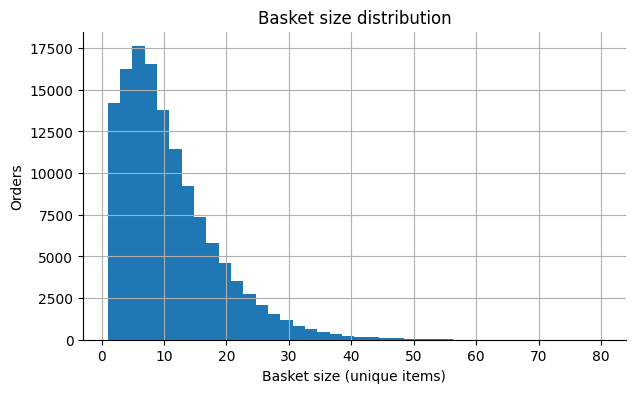

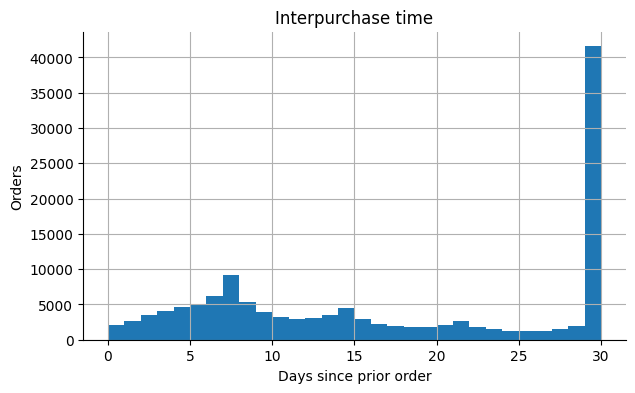

In [ ]:
#Dataset overview (basket size, recency)
# Basket size (train lines merged with user_id)
bs = opt_train_u.groupby("order_id")["product_id"].nunique()
plt.figure(); plt.hist(bs, bins=40); plt.xlabel("Basket size (unique items)"); plt.ylabel("Orders"); plt.title("Basket size distribution"); plt.show()

# Days since prior order (from orders)
if "days_since_prior_order" in orders.columns:
    rec = orders.loc[orders["eval_set"].eq("train"), "days_since_prior_order"].dropna()
    plt.figure(); plt.hist(rec, bins=30); plt.xlabel("Days since prior order"); plt.ylabel("Orders"); plt.title("Interpurchase time"); plt.show()


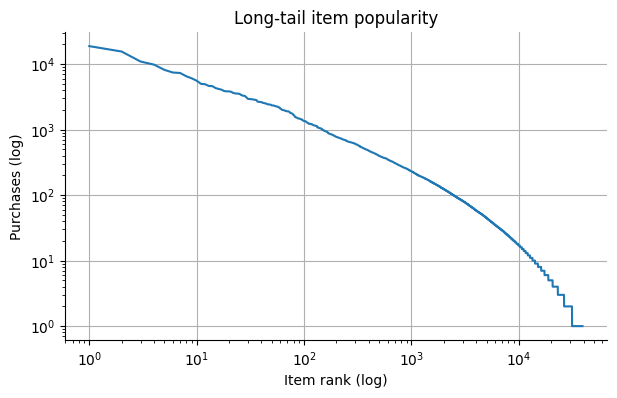

In [ ]:
#Long tail popularity
pop = opt_train_u["product_id"].value_counts().sort_values(ascending=False).reset_index(drop=True)
plt.figure()
plt.loglog(np.arange(1,len(pop)+1), pop.values)
plt.xlabel("Item rank (log)"); plt.ylabel("Purchases (log)"); plt.title("Long-tail item popularity"); plt.show()


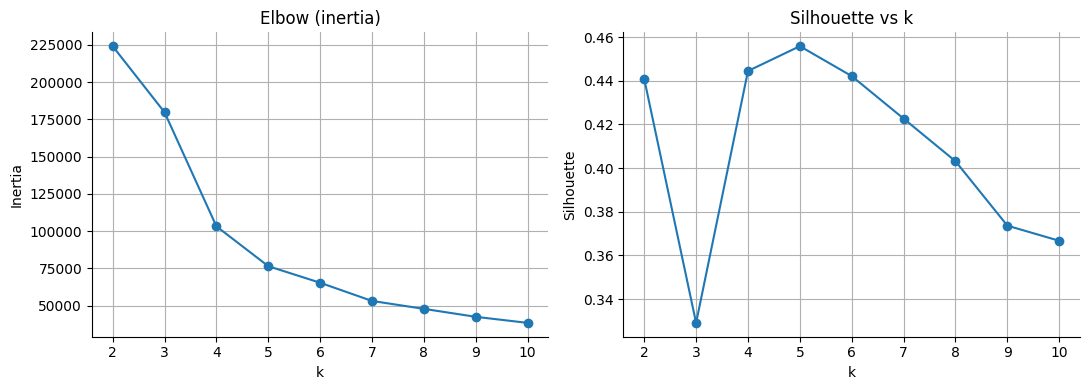

In [142]:
#Elbow & Silhouette for K-Means (user features)
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 1) Simple behavioural features per user
ufreq  = opt_train_u.groupby("user_id")["order_id"].nunique().rename("orders")
ukinds = opt_train_u.groupby("user_id")["product_id"].nunique().rename("unique_items")

# avg basket size per user: compute basket size per order, then average per user
order_bsize = opt_train_u.groupby("order_id")["product_id"].nunique().rename("basket_size")
order_uid   = opt_train_u.groupby("order_id")["user_id"].first()
ubsize = (pd.concat([order_bsize, order_uid], axis=1)
          .groupby("user_id")["basket_size"].mean()
          .rename("avg_basket"))

# recency: minimum days_since_prior_order across the user's train orders
if "days_since_prior_order" in orders.columns:
    rec = (orders.loc[orders["eval_set"].eq("train"), ["user_id","days_since_prior_order"]]
                 .dropna()
                 .groupby("user_id")["days_since_prior_order"].min()
                 .rename("recency"))
else:
    rec = pd.Series(0, index=ufreq.index, name="recency")

# assemble feature matrix
U = pd.concat([ufreq, ukinds, ubsize, rec], axis=1).fillna(0)

# scale
X = StandardScaler().fit_transform(U.values)

# 2) K sweep
Ks = list(range(2, 11))
inertia, silh = [], []
for k in Ks:
    try:
        km = KMeans(n_clusters=k, n_init="auto", random_state=42).fit(X)  # sklearn >=1.4
    except TypeError:
        km = KMeans(n_clusters=k, n_init=10,   random_state=42).fit(X)    # older sklearn
    inertia.append(km.inertia_)
    silh.append(silhouette_score(X, km.labels_))

# 3) Plots
fig, ax = plt.subplots(1, 2, figsize=(11, 4))
ax[0].plot(Ks, inertia, marker="o");  ax[0].set_title("Elbow (inertia)")
ax[0].set_xlabel("k"); ax[0].set_ylabel("Inertia")
ax[1].plot(Ks, silh, marker="o");    ax[1].set_title("Silhouette vs k")
ax[1].set_xlabel("k"); ax[1].set_ylabel("Silhouette")
plt.tight_layout(); plt.show()



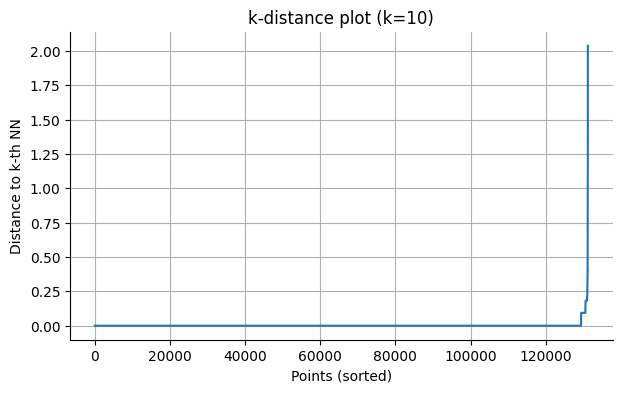

In [143]:
from sklearn.neighbors import NearestNeighbors

k = 10  # kth neighbour
nbrs = NearestNeighbors(n_neighbors=k, algorithm="auto").fit(X)
distances, _ = nbrs.kneighbors(X)
k_dists = np.sort(distances[:, -1])  # distance to k-th nearest neighbour
plt.figure(); plt.plot(k_dists); plt.title(f"k-distance plot (k={k})"); plt.xlabel("Points (sorted)"); plt.ylabel("Distance to k-th NN")
plt.show()
# Choose eps near the 'knee' of this curve.


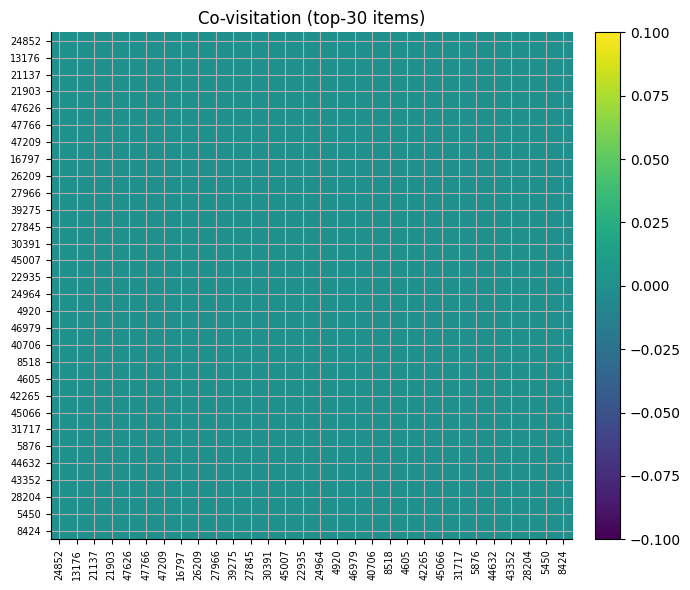

In [144]:
# Requires a co-vis matrix II and product mapping; build a small heatmap over top-N popular items
N = 30
top_items = opt_train_u["product_id"].value_counts().head(N).index.tolist()
# Map to indices
items_index = pd.Index(sorted(prods["product_id"].unique()), name="product_id")
p2i = {p:i for i,p in enumerate(items_index)}
subset_idx = [p2i[p] for p in top_items if p in p2i]

# If you built II elsewhere:
try:
    from scipy import sparse as _sp
    II_slice = II.tocsr()[subset_idx, :][:, subset_idx].toarray()
    fig, ax = plt.subplots(figsize=(7,6))
    im = ax.imshow(II_slice, aspect="auto")
    ax.set_title("Co-visitation (top-30 items)"); plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set_xticks(range(len(subset_idx))); ax.set_yticks(range(len(subset_idx)))
    ax.set_xticklabels([str(p) for p in top_items], rotation=90, fontsize=7)
    ax.set_yticklabels([str(p) for p in top_items], fontsize=7)
    plt.tight_layout(); plt.show()
except NameError:
    print("II matrix not found in memory; skip this cell or load artifacts/model/II_covisit.npz.")


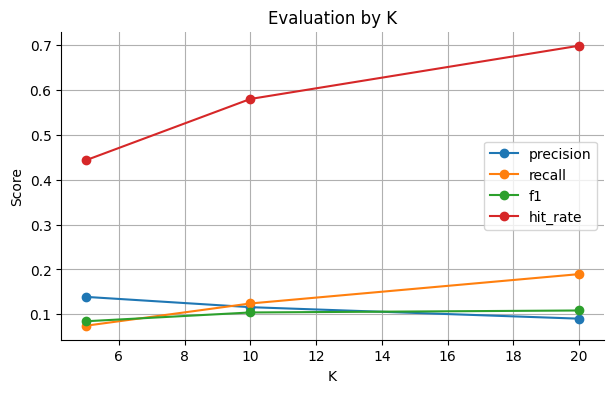

    K        user_id  precision    recall        f1  hit_rate
0   5  103166.825317   0.138846  0.074576  0.084517  0.443377
1  10  103166.825317   0.115915  0.124153  0.104107  0.579869
2  20  103166.825317   0.090314  0.189577  0.108527  0.698534


In [145]:
metrics_fp = Path("artifacts/metrics/eval_at_k.csv")
ev = pd.read_csv(metrics_fp) if metrics_fp.exists() else eval_agg.copy()
for col in ["precision","recall","f1","hit_rate"]:
    plt.plot(ev["K"], ev[col], marker="o", label=col)
plt.xlabel("K"); plt.ylabel("Score"); plt.title("Evaluation by K"); plt.legend(); plt.show()
print(ev)


In [148]:
import numpy as np, pandas as pd

# ---- behavioural features per user ----
# orders per user
ufreq  = opt_train_u.groupby("user_id")["order_id"].nunique().rename("orders")

# unique items a user bought
ukinds = opt_train_u.groupby("user_id")["product_id"].nunique().rename("unique_items")

# average basket size per user
order_bsize = opt_train_u.groupby("order_id")["product_id"].nunique().rename("basket_size")
order_uid   = opt_train_u.groupby("order_id")["user_id"].first()
ubsize = (pd.concat([order_bsize, order_uid], axis=1)
          .groupby("user_id")["basket_size"].mean()
          .rename("avg_basket"))

# recency = minimum days-since-prior-order across user's TRAIN orders (lower = more recent)
if "days_since_prior_order" in orders.columns:
    rec = (orders.loc[orders["eval_set"].eq("train"), ["user_id","days_since_prior_order"]]
                 .dropna()
                 .groupby("user_id")["days_since_prior_order"].min()
                 .rename("recency"))
else:
    rec = pd.Series(0, index=ufreq.index, name="recency")

# optional: reorder rate (if column exists in train)
if "reordered" in opt_train_u.columns:
    rrate = opt_train_u.groupby("user_id")["reordered"].mean().rename("reorder_rate")
else:
    rrate = None

parts = [ufreq, ukinds, ubsize, rec] + ([rrate] if rrate is not None else [])
U = pd.concat(parts, axis=1).fillna(0).sort_index()
U.index.name = "user_id"

print("U shape:", U.shape)
U.head()


U shape: (131209, 5)


,orders,unique_items,avg_basket,recency,reorder_rate
user_id,,,,,
1,1,11,11.0,14.0,0.909091
2,1,31,31.0,30.0,0.387097
5,1,9,9.0,6.0,0.444444
7,1,9,9.0,6.0,0.888889
8,1,18,18.0,10.0,0.222222


In [149]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# scale features
X = StandardScaler().fit_transform(U.values)

# choose k by silhouette over a small grid
K_grid = list(range(3, 9))
best_k, best_sil, best_km = None, -1.0, None
for k in K_grid:
    try:
        km = KMeans(n_clusters=k, n_init="auto", random_state=42).fit(X)  # sklearn >=1.4
    except TypeError:
        km = KMeans(n_clusters=k, n_init=10,   random_state=42).fit(X)    # older sklearn
    sil = silhouette_score(X, km.labels_)
    if sil > best_sil:
        best_k, best_sil, best_km = k, sil, km

labels = best_km.labels_
kmeans_assign = pd.DataFrame({"user_id": U.index, "cluster": labels}, index=None)

print(f"[Segmentation] Best k={best_k} | silhouette={best_sil:.3f}")
print("Cluster sizes:\n", kmeans_assign["cluster"].value_counts().sort_index())

# (optional) save for later use / the app
from pathlib import Path
artifacts_dir = Path.cwd() / "artifacts"
(artifacts_dir / "segments").mkdir(parents=True, exist_ok=True)
kmeans_assign.to_csv(artifacts_dir / "segments" / "kmeans_assign.csv", index=False)


[Segmentation] Best k=7 | silhouette=0.334
Cluster sizes:
 cluster
0     7277
1    27709
2    19719
3    19994
4    20855
5    19797
6    15858
Name: count, dtype: int64


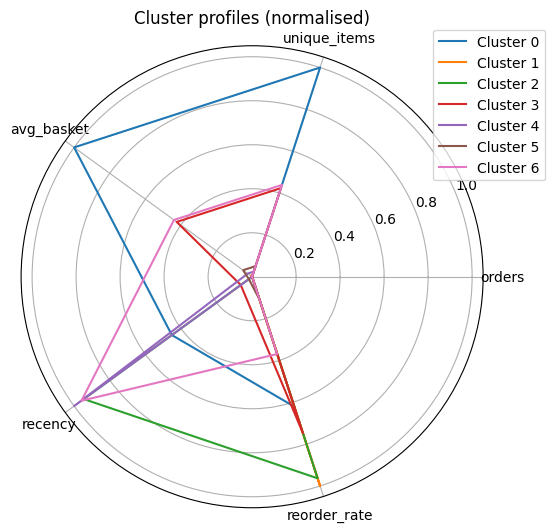

In [150]:
import numpy as np, matplotlib.pyplot as plt

if "kmeans_assign" in globals():
    U2 = U.join(kmeans_assign.set_index("user_id")["cluster"], how="inner")
    prof = U2.groupby("cluster").mean()
    prof_norm = (prof - prof.min()) / (prof.max() - prof.min() + 1e-9)

    labels = prof_norm.columns.tolist()
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    angles = np.concatenate([angles, [angles[0]]])

    fig = plt.figure(figsize=(8,6)); ax = plt.subplot(111, polar=True)
    for c in prof_norm.index:
        vals = prof_norm.loc[c, :].values
        vals = np.concatenate([vals, [vals[0]]])
        ax.plot(angles, vals, linewidth=1.5, label=f"Cluster {c}")
    ax.set_thetagrids(angles[:-1]*180/np.pi, labels)
    ax.set_title("Cluster profiles (normalised)")
    ax.legend(bbox_to_anchor=(1.15, 1.05))
    plt.show()
else:
    print("kmeans_assign not found; run the K-Means cell first.")


In [155]:
# === Rebuild aligned artifacts: II_covisit.npz, X_content.npz, popularity.npy ===
import numpy as np, pandas as pd
from pathlib import Path
from collections import defaultdict, Counter
from scipy import sparse
import joblib

# --- inputs you already have in memory ---
# prods: products merged with aisles/departments
# opt_train_u: order_products__train with user_id merged
# orders: orders.csv (not strictly needed here)

artifacts = Path.cwd() / "artifacts"
model_dir = artifacts / "model"
model_dir.mkdir(parents=True, exist_ok=True)

# ---------- source of truth for item order ----------
maps_fp = model_dir / "indices_maps.joblib"
if maps_fp.exists():
    maps = joblib.load(maps_fp)
    items_index = pd.Index(maps["items_index"], name="product_id")
    users_index = pd.Index(maps["users_index"], name="user_id")
    u2i, p2i = maps["u2i"], maps["p2i"]
else:
    # If no maps yet, create consistent indices from your current data
    items_index = pd.Index(sorted(prods["product_id"].unique()), name="product_id")
    users_index = pd.Index(sorted(opt_train_u["user_id"].unique()), name="user_id")
    p2i = {p:i for i,p in enumerate(items_index)}
    u2i = {u:i for i,u in enumerate(users_index)}
    joblib.dump({"users_index": users_index.tolist(),
                 "items_index": items_index.tolist(),
                 "u2i": u2i, "p2i": p2i}, maps_fp)

n_items = len(items_index)
print("n_items =", n_items)

# ---------- popularity vector aligned to items_index ----------
pop_counts = opt_train_u["product_id"].value_counts()
pop = np.zeros(n_items, dtype=np.float32)
for pid, cnt in pop_counts.items():
    idx = p2i.get(int(pid))
    if idx is not None:
        pop[idx] = cnt
pop = pop / (pop.max() if pop.max() > 0 else 1.0)
np.save(model_dir / "popularity.npy", pop)
print("popularity.npy shape:", pop.shape)

# ---------- content matrix aligned to items_index ----------
from sklearn.preprocessing import OneHotEncoder
def make_ohe():
    # sklearn >=1.4 uses sparse_output
    try:
        return OneHotEncoder(sparse_output=True, handle_unknown="ignore")
    except TypeError:
        return OneHotEncoder(sparse=True, handle_unknown="ignore")

cat = (prods.set_index("product_id")
             .reindex(items_index)[["department","aisle"]]
             .fillna("Unknown"))
ohe = make_ohe()
Xc = ohe.fit_transform(cat)  # (n_items x n_features) CSR
from scipy.sparse import save_npz
save_npz(model_dir / "X_content.npz", Xc.tocsr())
print("X_content.npz shape:", Xc.shape)

# ---------- co-visitation matrix aligned to items_index ----------
COVISIT_TOPN      = 100   # neighbors to keep per item
MAX_BASKET_ITEMS  = 50    # cap items per order to limit pair explosion

covisit = defaultdict(Counter)
deg     = np.zeros(n_items, dtype=np.float32)

for oid, grp in opt_train_u.groupby("order_id"):
    # map basket to indices, cap length to avoid blow-ups
    idxs = [p2i.get(int(p)) for p in grp["product_id"].tolist()]
    idxs = [i for i in idxs if i is not None]
    if not idxs: 
        continue
    if len(idxs) > MAX_BASKET_ITEMS:
        idxs = idxs[:MAX_BASKET_ITEMS]
    uniq = list(dict.fromkeys(idxs))
    # update popularity degree (for later normalization)
    for it in uniq: deg[it] += 1.0
    # undirected co-occurrence
    for i in range(len(uniq)):
        a = uniq[i]
        for j in range(i+1, len(uniq)):
            b = uniq[j]
            covisit[a][b] += 1
            covisit[b][a] += 1

# build CSR with top-N neighbors per row
indptr = [0]; indices = []; data = []
for a in range(n_items):
    neigh = covisit.get(a)
    if not neigh:
        indptr.append(indptr[-1]); continue
    k = sorted(neigh.items(), key=lambda t:t[1], reverse=True)[:COVISIT_TOPN]
    if k:
        js, vs = zip(*k)
        indices.extend(js)
        data.extend(vs)
        indptr.append(indptr[-1] + len(js))
    else:
        indptr.append(indptr[-1])

II = sparse.csr_matrix(
    (np.array(data, dtype=np.float32),
     np.array(indices, dtype=np.int32),
     np.array(indptr, dtype=np.int32)),
    shape=(n_items, n_items)
)

# symmetric degree normalization: D^{-1/2} II D^{-1/2}
row_sums = np.asarray(II.sum(axis=1)).ravel()
row_sums = np.maximum(row_sums, 1e-9)
Dinv = sparse.diags(1.0/np.sqrt(row_sums))
II = (Dinv @ II @ Dinv).tocsr()

save_npz(model_dir / "II_covisit.npz", II)
print("II_covisit.npz shape:", II.shape)

print("\n[OK] Rebuilt artifacts with a consistent item universe.")


n_items = 48808
popularity.npy shape: (48808,)
X_content.npz shape: (48808, 155)
II_covisit.npz shape: (48808, 48808)

[OK] Rebuilt artifacts with a consistent item universe.


Shapes → II: (48808, 48808)  | Xc: (48808, 155)  | pop: (48808,)  | len(items_index): 48808


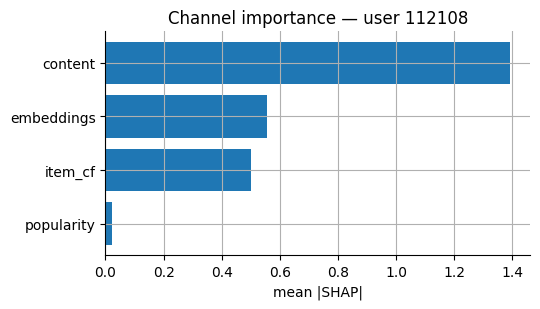

In [156]:
# === SHAP (robust) — checks shapes, aligns indices, then explains one user ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt, joblib
from pathlib import Path
from scipy import sparse

model_dir = Path.cwd() / "artifacts" / "model"

# --- load maps & matrices if missing ---
if "u2i" not in globals() or "items_index" not in globals():
    maps = joblib.load(model_dir / "indices_maps.joblib")
    users_index = pd.Index(maps["users_index"], name="user_id")
    items_index = pd.Index(maps["items_index"], name="product_id")
    u2i, p2i = maps["u2i"], maps["p2i"]

if "II" not in globals():  II = sparse.load_npz(model_dir / "II_covisit.npz").tocsr()
if "Xc" not in globals():  Xc = sparse.load_npz(model_dir / "X_content.npz").tocsr()
if "pop" not in globals(): pop = np.load(model_dir / "popularity.npy")

Uemb = globals().get("Uemb", None); Vemb = globals().get("Vemb", None)
if Uemb is None and (model_dir / "Uemb.npy").exists():
    Uemb = np.load(model_dir / "Uemb.npy"); Vemb = np.load(model_dir / "Vemb.npy")

# user_seen (build from opt_train_u if not exported)
if "user_seen" not in globals():
    user_seen = {}
    for uid0, grp in opt_train_u.groupby("user_id"):
        uidx0 = u2i.get(uid0)
        if uidx0 is None: 
            continue
        user_seen[uidx0] = { p2i[p] for p in grp["product_id"].unique() if p in p2i }

# --- shape diagnostics ---
n_items_II, n_items_Xc, n_items_pop = II.shape[0], Xc.shape[0], pop.shape[0]
print("Shapes → II:", II.shape, " | Xc:", Xc.shape, " | pop:", pop.shape,
      " | len(items_index):", len(items_index))
if not (n_items_II == n_items_Xc == n_items_pop):
    raise ValueError("Artifact size mismatch: II/Xc/pop must have same #rows.")
n_items = n_items_II

# If items_index doesn’t match n_items, we’ll create a safe fallback product_id array
def _product_ids_aligned():
    if 'items_index' in globals() and len(items_index) == n_items:
        return np.asarray(items_index, dtype=int)
    # try invert p2i
    if 'p2i' in globals():
        inv = {v:k for k,v in p2i.items()}
        return np.array([inv.get(i, i) for i in range(n_items)], dtype=int)
    return np.arange(n_items, dtype=int)

def _row_norms_csr(M):
    return np.sqrt(M.multiply(M).sum(axis=1)).A1

def _mm(x):
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
    mx, mn = float(x.max()), float(x.min())
    return (x - mn) / (mx - mn + 1e-9) if mx > mn else np.zeros_like(x)

# --- robust channel table ---
def channel_table_for_user(uidx: int) -> pd.DataFrame:
    seen = user_seen.get(uidx, set())
    s_cf = np.zeros(n_items, dtype=np.float32)
    s_ct = np.zeros(n_items, dtype=np.float32)
    s_em = np.zeros(n_items, dtype=np.float32)
    s_po = pop.astype(np.float32)

    if seen:
        seen_idx = np.array(sorted(list(seen)), dtype=int)
        sims = II[:, seen_idx].toarray()
        s_cf = sims.sum(axis=1, dtype=np.float32)

        centroid = np.asarray(Xc[seen_idx, :].mean(axis=0)).ravel()
        nc = float(np.linalg.norm(centroid))
        if nc > 0:
            numer = np.asarray(Xc @ centroid).ravel()
            denom = (_row_norms_csr(Xc) + 1e-9) * (nc + 1e-9)
            s_ct = (numer / denom).astype(np.float32)

    if (Uemb is not None) and (Vemb is not None) and (Vemb.shape[0] == n_items):
        u = Uemb[uidx:uidx+1, :]
        An = np.linalg.norm(u, axis=1, keepdims=True) + 1e-9
        Bn = (np.linalg.norm(Vemb, axis=1, keepdims=True) + 1e-9).T
        s_em = ((u @ Vemb.T).ravel() / (An * Bn).ravel()).astype(np.float32)

    df = pd.DataFrame({
        "item_cf": _mm(s_cf),
        "content": _mm(s_ct),
        "embeddings": _mm(s_em),
        "popularity": _mm(s_po),
    })
    df["product_id"] = _product_ids_aligned()
    return df

# --- pick a user & run SHAP ---
uid = int(opt_train_u["user_id"].iloc[0])  # change if needed
uidx = u2i[uid]
X = channel_table_for_user(uidx)

# labels: next TRAIN order items for this user
truth = set(opt_train_u.loc[opt_train_u.user_id==uid, "product_id"].astype(int).tolist())
X["y"] = X["product_id"].isin(truth).astype(int)
if X["y"].nunique() < 2:
    raise ValueError("This user yields a single class (all 0/1); pick a different user_id.")

from sklearn.linear_model import LogisticRegression
import shap

feat_cols = ["item_cf","content","popularity"] + (["embeddings"] if X["embeddings"].max()>0 else [])
clf = LogisticRegression(max_iter=500, class_weight="balanced", solver="lbfgs").fit(X[feat_cols], X["y"])

try:
    explainer = shap.Explainer(clf, X[feat_cols])
    sv = explainer(X[feat_cols]).values
except Exception:
    explainer = shap.LinearExplainer(clf, X[feat_cols], feature_perturbation="interventional")
    sv = explainer.shap_values(X[feat_cols])
    sv = sv if isinstance(sv, np.ndarray) else (sv[1] if isinstance(sv, list) and len(sv)>1 else sv[0])

shap_abs = np.abs(sv).mean(axis=0)
order = np.argsort(shap_abs)

plt.figure(figsize=(5.5,3.2))
plt.barh(np.array(feat_cols)[order], shap_abs[order])
plt.xlabel("mean |SHAP|")
plt.title(f"Channel importance — user {uid}")
plt.tight_layout()
plt.show()
